# 1. Motivation
We want to find out if humans have discovered yet that lab rats and dolphins are smarter than them so our question is: who’s the smartest animal in town? Our team decided that the best way to find out was to search the dark deep web of Facebook.


 __Choice of dataset__

Upon a search for the most relevant Facebook groups, 3 stood out (most members, >5000): Animal Cognition, Anthrozoology and Animal Cognition, the Emotional and Intellectual Lives of Animals. Our assumption is that everything posted on these groups is scientific and related to the intelligence of animals (due to the groups' names), so therefore if a post on these groups mentions an animal, that animal must be smart. 


# 2. Basic stats about the dataset

After using Facebook's API to download all the required materials, we ended up with the following datasets:



* __Animal Cognition:__


    - 6 956 posts
    - 4726 members
    - 9779 comments
    - 11887 mentioned animals


* __Animal Cognition, the Emotional and Intellectual Lives of Animals:__


    - 10 364 posts
    - 4825 members
    - 7928 comments
    - 15316 mentioned animals


* __Anthrozoology:__


    - 7 442 posts
    - 3200 members
    - 13750 comments
    - 9331 mentioned animals


* 24 762 posts in total, 78.3 MB of pickles

Also, Wikipedia was mined for a list of animals by common name. This list was chosen because it seemed the most relevant, as people mention animals by their common name (as opposed to the scientific one) when posting about them on facebook.


# 3. Tools, theory and analysis.

The imports needed to run the code:

In [414]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt #for drawing graphs
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10) #increase size of matplotlib drawing
import warnings; warnings.simplefilter('ignore') #don't show warnings related to deprecated methods
import networkx as nx
import matplotlib.pyplot as plt
import pickle, re
import nltk, collections,time
from sklearn.feature_extraction.text import TfidfVectorizer
import community
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


### Find out what animals the posts are about
One of the first things we needed to do after downloading the facebook groups material was to look at all the posts and find out which animals they are about. For that we downloaded a list of animals from wikipedia, defined a few methods to extract all the text from a post and used Regular Expressions to find the animals.

We also needed to look at the word stemmings, since lots of the times, the animals are e.g. in plural.

In [2]:
import pickle, re
import networkx as nx
import nltk, collections

# The 3 groups and their member list + posts
membersFiles = ["all_members_animal_cognition","all_members_animal_cognition_and_emotion","all_members_anthrozoology"]
postsFiles = ["all_posts_animal_cognition","all_posts_animal_cognition_and_emotion","all_posts_anthrozoology"]


In [4]:
all_membersDictionary= {group:pickle.load(open(group+'.pkl', 'rb')) for group in membersFiles}
all_postsDictionary = {group:pickle.load(open(group+'.pkl', 'rb')) for group in postsFiles}
# animalcog_members = pickle.load(open("all_members_animal_cognition"+'.pkl', 'rb'))
# animalcog_posts = pickle.load(open("all_posts_animal_cognition"+'.pkl', 'rb'))

### Method definitions

These helper methods are self explanatory (based on their names and parameter taken)

In [2]:
def removeNone(item):
    '''Converts a None item to an empty string, otherwise returns the original item'''
    if item==None:
        return ""
    else:
        return item
def numberOfReactions(post):
    if type(post['reactions'])==dict and post['reactions'].has_key('data'): #post.has_key('reactions') and
        return len(post['reactions']['data'])
    else:
        return 0
    
def numberOfComments(post):
    if type(post['comments'])==dict and post['comments'].has_key('data'):
        return len(post['comments']['data'])
    else:
        return 0
    
def getComments(post):
    if type(post['comments'])==dict and post['comments'].has_key('data'):
        return post['comments']['data']
    else:
        return None

def getReactions(post):
    if type(post['reactions'])==dict and post['reactions'].has_key('data'): #post.has_key('reactions') and
        return post['reactions']['data']
    else:
        return None
def getMessage(post):
    if post['message']!=0:
        return  post['message']
    else:
        return None
def getDescription(post):
    if post['description']!=0:
        return  post['description']
    else:
        return None
def getStory(post):
    if post['story']!=0:
        return  post['story']
    else:
        return None

def getUpdatedTime(post):
    return post['updated_time']

def getMessageFromComment(comment):
    if comment!=None:
        return comment['message']
    else: 
        return ""
    
def getMessagesFromComments_lvl1(comments):
    messages=""
    if comments!=None:
        for comment in comments:
            messages = messages + " " + getMessageFromComment(comment)
            
    return messages
def getMessagesFromComments_lvl2(comments):
    return ""
def getAllMessagesFromComments(comments):
    messages=""
    if comments!=None:
        for comment in comments:
            messages = messages + "\n" + getMessageFromComment(comment)
            if comment.has_key('comments'):
                messages = messages + "\n" + getMessagesFromComments_lvl1(getComments(comment))
                
    return messages

def getAttachments(post):
    if type(post['attachments'])==dict and post['attachments'].has_key('data'): #post.has_key('reactions') and
        return post['attachments']['data']
    else:
        return None 
def getAttachmentsText(attachments):
    text=""
    if attachments!=None:
        for attachment in attachments:
            if attachment.has_key('description'):
                text=text+attachment['description']+" "
            if attachment.has_key('title'):
                text=text+attachment['title']+" "
    return text
def getName(post):
    if post['name']!=0:
        return post['name']
    else:
        return None
def getCaption(post):
    if post['caption']!=0:
        return post['caption']
    else:
        return None
def getLink(post):
    if post['link']!=0:
        return post['link']
    else:
        return None
def getShares(post):
    if post['shares']!=0:
        return post['shares']
    else:
        return None
def getCreatedTime(post):
    if post['created_time']!=0:
        return post['created_time']
    else:
        return None
def getType(post):
    if post['type']!=0:
        return post['type']
    else:
        return None
def getStoryTags(post):
    if post['story_tags']!=0:
        return post['story_tags']
    else:
        return None
    
###Helper methods
def getAllTextFromPost(post):
    return getAllMessagesFromComments(getComments(post)) + "\n\n" + removeNone(getDescription(post)) \
+ "\n" + removeNone(getMessage(post))  +  "\n" + removeNone(getAttachmentsText(getAttachments(post))) \
+  "\n" + removeNone(getCaption(post)) # + removeNone(getName(post)) + 

def getTextTokensFromPost(post):
    return post['text_tokens']
def getTextTokensStemmedFromPost(post):
    return post['text_tokens_stemmed']

def getUserIDsFromReactions(reactions):
    if reactions!=None:
        return [user['id'] for user in reactions]
    else:
        return set()
    
def getUserIDsFromComments(comments):
    userIDs=set()
    if comments!=None:
        for comment in comments:
            if getFromID(comment)!=None: #some replies don't have the From field (possibly due to accounts disabled?)
                userIDs.add(getFromID(comment))
            if comment.has_key('comments'):
                for reply in getComments(comment):
                    if getFromID(comment)!=None: #some replies don't have the From field (possibly due to accounts disabled?)
                        userIDs.add(getFromID(comment))
#     print userIDs            
    return userIDs

def getFrom(post):
    if post.has_key('from'):
        return post['from']
    else:
#         print post
        return None
def getAuthorID(post):
    if getFrom(post)!=None and getFrom(post).has_key('id'):
        return getFrom(post)['id']
    else:
        return None
def getAuthorName(post):
    if getFrom(post)!=None and getFrom(post).has_key('name'):
        return getFrom(post)['name']
    else:
        return None
def getAuthor(post):
    return getFrom(post)
def getFromID(post):
    return getAuthorID(post)
def getFromName(post):
    return getAuthorName(post)

Next, we create another entry in the post dictionary containing all the word tokens + their stems present in its text:

In [7]:
for group in all_postsDictionary.values():
    porter = nltk.PorterStemmer()
    for postId,post in group.items():
        post.update({'text_tokens':[word.lower() for word in re.findall(r"\b[a-zA-Z]{2,}\b", getAllTextFromPost(post))]})
        post.update({'text_tokens_stemmed':[porter.stem(word) for word in post['text_tokens']]})

# #pickle them so no need to redo the above 
# for name,group in all_postsDictionary.iteritems():
#     pickle.dump(group, open(name+"_with_text_tokens.pkl", "wb"))

Import list of animals (downloaded from Wikipedia) and remove items that have parantheses (which are useful only to wikipedia)

In [47]:
list_all_animals = set([re.sub("\s*[\(\[].*?[\)\]]", "",animal.lower()) for animal in pickle.load(open("from_anula/list_all_animals.pkl",'rb'))]) #make it a set
list_all_animals.remove("human")###########todo: make sure it's not here at all in the pickle
list_all_animals.remove("herring")####due to red herring. sorry smart herrings!

Make a dictionary out of all the animals in *list_of_animals* containing all the possible derivations (stems, splits by '|')

In [9]:
# dictionary_all_animals = {animal:set([item,porter.stem(item)]) for animal in list_all_animals for item in animal.split('|')}
dictionary_all_animals = {animal:{'nonStemmed':[],'stemmed':[],'multipleWords':[]} for animal in list_all_animals}
for animal in list_all_animals:
    dictionary_all_animals[animal]['nonStemmed'] = set([item for item in animal.split('|')])
    dictionary_all_animals[animal]['stemmed'] = set([porter.stem(item) for item in dictionary_all_animals[animal]['nonStemmed']])
    dictionary_all_animals[animal]['multipleWords']= set([item for item in dictionary_all_animals[animal]['nonStemmed'] if len(item.split(" "))>=2])
# print dictionary_all_animals


The cell below is where the animals are found. Animals made of multiple names are also found. We're also checking word stemmings when finding animals in the posts' text.

In [8]:
################### With stems
import re, nltk, collections,pickle
porter = nltk.PorterStemmer()
for groupName,group in all_postsDictionary.iteritems():
    animals_score = {animal:0 for animal in list_all_animals}

    postsWithNoAnimalsFound=[]
    for postId,post in group.iteritems():
        found_animals=[]
        textTokens = getTextTokensFromPost(post)
        textTokensStemmed = getTextTokensStemmedFromPost(post)

        ###searches all single words from post in listofanimals
        for index in range(len(textTokens)):
            for animal in dictionary_all_animals.keys():
                if textTokens[index] in dictionary_all_animals[animal]['nonStemmed']:
                    found_animals.append(animal)
                elif textTokensStemmed[index] in dictionary_all_animals[animal]['nonStemmed']:
                    found_animals.append(animal)
                elif textTokensStemmed[index] in dictionary_all_animals[animal]['stemmed']:
                    found_animals.append(animal)


        ###searches all multiple-worded animals of listofanimals in text of post
        for key in dictionary_all_animals.keys():
            for animal in dictionary_all_animals[key]['multipleWords']:
                if animal in getAllTextFromPost(post).lower():
                    found_animals.append(key)        

   
            
        ##add the found animals to the post
        group[postId].update({'animals_detected':set(found_animals)})
        #find the most talked about animal as the subject of the post
        animals_subject=[]
        for animal,counter in collections.Counter(found_animals).items():
            if counter==max(collections.Counter(found_animals).values()):
                animals_subject.append(animal)
        group[postId].update({'animals_subject':animals_subject})

        for animal in animals_subject:
            animals_score[animal]+=1
        if len(found_animals)==0:
            postsWithNoAnimalsFound.append(postId)

# Most liked animal in each group

* __Most liked animal in Animal Cognition:__ (based on reactions to post)

reactions_animal_cognition = {animal: 0  for animal in list_all_animals}

for ID, post in posts_animal_cognition.iteritems():
    if   (posts_animal_cognition[ID]['reactions'] != 0):        
        reactions = len(posts_animal_cognition[ID]['reactions']['data'])
        if (posts_animal_cognition[ID]['animals_subject'] != 0):
            for i in (posts_animal_cognition[ID]['animals_subject']):
                reactions_animal_cognition[i] += reactions
            
sorted_reactions_animal_cognition = sorted(reactions_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)

Top 10 most liked animals in Animal Cognition:

for animal in sorted_reactions_animal_cognition[:10]:
    print animal

* __Most liked animal in Animal Cognition and Emotional Intelligence:__ (based on reactions to post)

reactions_animal_cognition_and_emotion = {animal: 0  for animal in list_all_animals}

for ID, post in posts_animal_cognition_and_emotion.iteritems():
    if   (posts_animal_cognition_and_emotion[ID]['reactions'] != 0):        
        reactions = len(posts_animal_cognition_and_emotion[ID]['reactions']['data'])
        if (posts_animal_cognition_and_emotion[ID]['animals_subject'] != 0):
            for i in (posts_animal_cognition_and_emotion[ID]['animals_subject']):
                reactions_animal_cognition_and_emotion[i] += reactions
            
sorted_reactions_animal_cognition_and_emotion = sorted(reactions_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)

Top 10 most liked animals in Animal Cognition and Emotional Intelligence:

for animal in sorted_reactions_animal_cognition_and_emotion[:10]:
    print animal
    ####Pickle the updated posts 
    pickle.dump(group, open(groupName+"_updated.pkl", "wb"))

    #posts with no found animals
    pickle.dump(postsWithNoAnimalsFound, open("PostsWithNoAnimalsFound_withStems_"+groupName+".pkl", "wb"))
    print len(postsWithNoAnimalsFound)


### Preliminary conclusion: most liked animal in each group

* __Most liked animal in Animal Cognition:__ (based on reactions to post)

In [387]:
reactions_animal_cognition = {animal: 0  for animal in list_all_animals}

for ID, post in posts_animal_cognition.iteritems():
    if   (posts_animal_cognition[ID]['reactions'] != 0):        
        reactions = len(posts_animal_cognition[ID]['reactions']['data'])
        if (posts_animal_cognition[ID]['animals_subject'] != 0):
            for i in (posts_animal_cognition[ID]['animals_subject']):
                reactions_animal_cognition[i] += reactions
            
sorted_reactions_animal_cognition = sorted(reactions_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)

Top 10 most liked animals in Animal Cognition:

In [388]:
for animal in sorted_reactions_animal_cognition[:10]:
    print animal

(u'dog|huski|dachshund|canine', 6739)
(u'bird', 4268)
(u'cat', 2573)
(u'chimpanzee|chimp', 2442)
(u'elephant', 1603)
(u'crow', 1498)
(u'monkey', 1389)
(u'dolphin', 1352)
(u'fish', 1238)
(u'parrot', 1017)


* __Most liked animal in Animal Cognition and Emotional Intelligence:__ (based on reactions to post)

In [391]:
reactions_animal_cognition_and_emotion = {animal: 0  for animal in list_all_animals}

for ID, post in posts_animal_cognition_and_emotion.iteritems():
    if   (posts_animal_cognition_and_emotion[ID]['reactions'] != 0):        
        reactions = len(posts_animal_cognition_and_emotion[ID]['reactions']['data'])
        if (posts_animal_cognition_and_emotion[ID]['animals_subject'] != 0):
            for i in (posts_animal_cognition_and_emotion[ID]['animals_subject']):
                reactions_animal_cognition_and_emotion[i] += reactions
            
sorted_reactions_animal_cognition_and_emotion = sorted(reactions_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)

Top 10 most liked animals in Animal Cognition and Emotional Intelligence:

In [393]:
for animal in sorted_reactions_animal_cognition_and_emotion[:10]:
    print animal

(u'dog|huski|dachshund|canine', 8158)
(u'elephant', 5116)
(u'whale', 3564)
(u'bird', 2674)
(u'horse', 2482)
(u'cat', 2427)
(u'dolphin', 2324)
(u'cattle|cow|calves', 1677)
(u'bear', 1670)
(u'fish', 1562)


* __Most liked animal in Anthrozoology:__ (based on reactions to post)

In [394]:
reactions_anthrozoology = {animal: 0  for animal in list_all_animals}

for ID, post in posts_anthrozoology.iteritems():
    if   (posts_anthrozoology[ID]['reactions'] != 0):        
        reactions = len(posts_anthrozoology[ID]['reactions']['data'])
        if (posts_anthrozoology[ID]['animals_subject'] != 0):
            for i in (posts_anthrozoology[ID]['animals_subject']):
                reactions_anthrozoology[i] += reactions
            
sorted_reactions_anthrozoology = sorted(reactions_anthrozoology.items(), key=operator.itemgetter(1), reverse = 1)

Top 10 most liked animals in Anthropology:

In [395]:
for animal in sorted_reactions_anthrozoology[:10]:
    print animal

(u'dog|huski|dachshund|canine', 7019)
(u'elephant', 2297)
(u'bird', 1986)
(u'cat', 1951)
(u'horse', 1916)
(u'wolf|wolves', 1287)
(u'chimpanzee|chimp', 943)
(u'bear', 917)
(u'whale', 858)
(u'fish', 783)


By looking at the number of likes each animal post received, we can see an interesting indication which may or may not indicate that those animals are smart. Cats and dogs are both out there, and since they have been artificially bred by us, we like them more and know them better than other animals. This bias may explain why they are in the top. 

However, another thing is clear: on all 3 groups, dogs > cats. 

## Next - Create the network
Now that we've found the animals in the posts we can build the network like this:
* Nodes: 
    * Members by ID
    * Posts by ID with comments as attributes
    * Animals by name
* Edges:
    * Members - posts: if a member posted/liked/commented on the post (with post/like/comment as edge attribute)
    * Posts - animals: if the animal is the subject of the post (as found in the 'animals_subject' value of the post dictionary)
 

In [ ]:
import pickle, re
import networkx as nx
import nltk, collections


###### Uncomment if all posts and members are needed in the same variable. Otherwise only 1 group is selected at a time (due to possible memory restrictions)
membersFiles = ["all_members_animal_cognition","all_members_animal_cognition_and_emotion","all_members_anthrozoology"]
postsFiles = ["all_posts_animal_cognition_updated","all_posts_animal_cognition_and_emotion_updated","all_posts_anthrozoology_updated"]

###### Uncomment if memory is a problem and you want to run the analysis on only 1 group at a time
# membersFiles = ["all_members_anthrozoology"]
# postsFiles = ["all_posts_anthrozoology_updated"]
######

all_membersDictionary= {group:pickle.load(open(group+'.pkl', 'rb')) for group in membersFiles}
all_postsDictionary = {group:pickle.load(open(group+'.pkl', 'rb')) for group in postsFiles}

In [380]:
###### This is what you need to change to do it for a different group
groupName = "animalcognition"
groupPosts = all_postsDictionary['all_posts_animal_cognition_updated']
groupMembers = all_membersDictionary['all_members_animal_cognition'] 

# The file names:
# membersFiles = ["all_members_animal_cognition","all_members_animal_cognition_and_emotion","all_members_anthrozoology"]
# postsFiles = ["all_posts_animal_cognition_updated","all_posts_animal_cognition_and_emotion_updated","all_posts_anthrozoology_updated"]

#####################################################################

multipartiteGraph = nx.Graph()
multipartiteGraph.add_nodes_from(groupMembers.keys(), nodeType='user',color='blue')
multipartiteGraph.add_nodes_from(groupPosts.keys(), nodeType='post',color='red')
multipartiteGraph.add_nodes_from(list_all_animals, nodeType='animal',color='green')


In [381]:
#add edges from posts to animals(only the subjects of the posts)
multipartiteGraph.add_edges_from([(postID, animal) for postID in groupPosts.iterkeys() \
                                  for animal in groupPosts[postID]['animals_subject'] \
                                  if len(groupPosts[postID]['animals_subject'])>0]\
                                 ,edgeType=['animalSubject']) #is edgetype correct?

# #add edges from posts to animals(all the animals found in a post)
# multipartiteGraph.add_edges_from([(postID, animal) for postID in groupPosts.iterkeys() \
#                                   for animal in groupPosts[postID]['animals_detected'] \
#                                   if len(groupPosts[postID]['animals_detected'])>0]\
#                                  ,edgeType=['animalDetected']) #is edgetype correct?


#add edges from users to posts
for postID,post in groupPosts.iteritems():
    #add edges from author to its post
    authorID=getAuthorID(post)
    if multipartiteGraph.has_edge(authorID,postID) and multipartiteGraph[authorID][postID].has_key('edgeType'):
        multipartiteGraph[authorID][postID]['edgeType'].add('author')
    elif multipartiteGraph.has_node(authorID): 
        multipartiteGraph.add_edges_from([(authorID,postID)], edgeType=set(['author']))
    
    #add edges from users that gave reactions to the post
    if numberOfReactions(post)>0:
        for userID in getUserIDsFromReactions(getReactions(post)):
            if multipartiteGraph.has_edge(userID,postID) and multipartiteGraph[userID][postID].has_key('edgeType'):
                multipartiteGraph[userID][postID]['edgeType'].add('reaction')
            elif multipartiteGraph.has_node(userID): 
                multipartiteGraph.add_edge(userID,postID, edgeType=set(['reaction']))
   
    #add edges from users that commented to the post
    if numberOfComments(post)>0:
        for userID in getUserIDsFromComments(getComments(post)):
            if multipartiteGraph.has_edge(userID,postID) and multipartiteGraph[userID][postID].has_key('edgeType'):
                multipartiteGraph[userID][postID]['edgeType'].add('comment')
            elif multipartiteGraph.has_node(userID): 
                multipartiteGraph.add_edge(userID,postID, edgeType=set(['comment'])) 
                
# print len([userNode for userNode,attributes \
#           in multipartiteGraph.nodes_iter(data=True) \
#           if len(attributes)==0])

In [90]:
 ####Pickle the graph
pickle.dump(multipartiteGraph, open("multipartiteGraph_"+groupName+".pkl", "wb"))

#####Unpickle the graph
# multipartiteGraph=pickle.load(open("multipartiteGraph_"+groupName+".pkl", 'rb'))

## Network analysis
Currently, the graph we built is a multipartite graph made of 3 types of nodes: users,posts and animals. We can do a preliminary betweenness centrality analysis to see which nodes are central in the multipartite network. After that, we will project the animal subgraph and analyze it more in depth.

#### Calculating the betweenness centrality for the multipartite graph

In [2]:
### Note: since it takes a long time, just use the pickle below
print multipartiteGraph.number_of_nodes(), " ", multipartiteGraph.number_of_edges()
GCC_multipartiteGraph=max(nx.connected_component_subgraphs(multipartiteGraph,copy=True), key=len)
print GCC_multipartiteGraph.number_of_nodes(), " ", GCC_multipartiteGraph.number_of_edges()

start_time = time.time()
between_centrality = nx.betweenness_centrality(GCC_multipartiteGraph)
########### Sort posts by number of reactions and print the number of reactions  
elapsed_time = time.time() - start_time
print elapsed_time####Pickle the between_centrality since it took 30 minutes
# pickle.dump(between_centrality, open("betweenCentralityGCC_"+groupName+".pkl", "wb")) 

#####Unpickle the between_centrality
between_centrality=pickle.load(open("betweenCentralityGCC_"+groupName+".pkl", 'rb'))

In [5]:
####Pickle the between_centrality since it took 30 minutes
# pickle.dump(between_centrality, open("betweenCentralityGCC_"+groupName+".pkl", "wb")) 
#####Unpickle the between_centrality
between_centrality=pickle.load(open("betweenCentralityGCC_"+groupName+".pkl", 'rb'))

In [6]:
for node,betweenness in sorted(between_centrality.iteritems(), reverse=True, key= lambda node: node[1])[:10]:
    print node, ":",betweenness

1322360307909727 : 0.160884981514
10216027383903846 : 0.139725685894
10155670551195985 : 0.0837083637737
10214955589106892 : 0.0575954930295
1720034408041981 : 0.0510354890295
dog|huski|dachshund|canine : 0.0505594877606
904099763117069 : 0.0380355611004
10155814262253187 : 0.0351279705888
10155957749097509 : 0.0264948992577
10213805281742736 : 0.0260411898794


Only 1 animal node is in top 10 betweenness centrality, the rest are users. This means that there are a few users who post many times about different animals. Also, this indicates that dogs are special in the graph(as we will see further down, they are also the most talked about animal)

### Next, project the animal subgraph to analyze it in more depth

In [7]:
import copy
##Remove the user nodes to be able to project subgraph
animal_subgraph = copy.deepcopy(multipartiteGraph)
animal_subgraph.remove_nodes_from([userNode for userNode,attributes \
                                   in animal_subgraph.nodes_iter(data=True) \
                                   if attributes['nodeType']=='user'])

animal_subgraph = nx.bipartite.projected_graph(animal_subgraph, \
                             [animalNode for animalNode,attributes in animal_subgraph.nodes_iter(data=True)\
                             if attributes['nodeType']=='animal'])

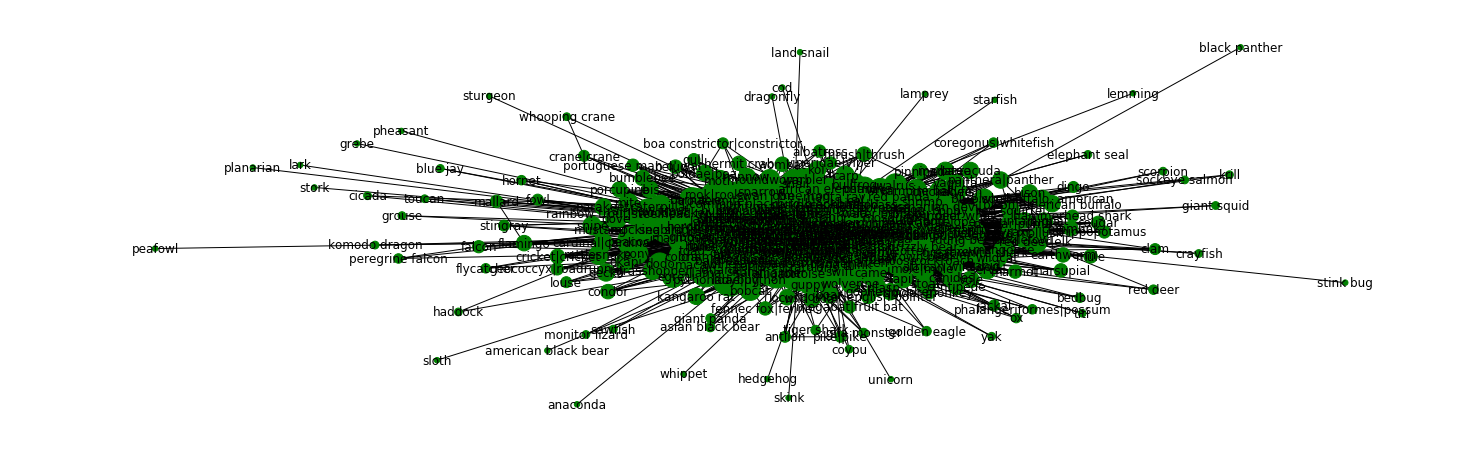

In [142]:
#Draw graph where the size of nodes is proportional to node degree
# animal_subgraph_noZeroDegrees = copy.deepcopy(animal_subgraph)
# animal_subgraph_noZeroDegrees.remove_nodes_from([animalNode for animalNode in animal_subgraph.nodes() \
#                                                  if animal_subgraph.degree(animalNode)==0])
animal_subgraph_GCC = list(nx.connected_component_subgraphs(animal_subgraph))[0]

degree = animal_subgraph_GCC.degree().values()
nx.draw(animal_subgraph_GCC, node_size = [v*30 for v in degree], node_color = 'g', with_labels=True)
# nx.draw_networkx()

Let's look at the degree distribution of the network

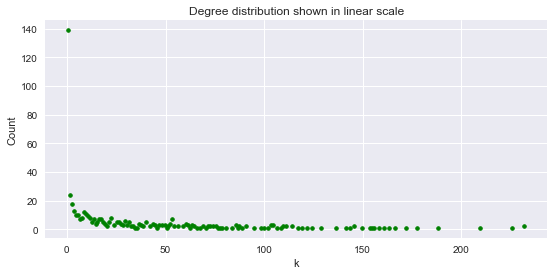

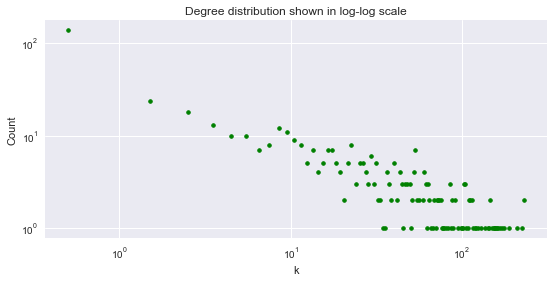

In [238]:
count, bins = np.histogram(animal_subgraph.degree().values(),bins=sorted(list(set(animal_subgraph.degree().values()))))

plt.figure(211)
plt.title("Degree distribution shown in linear scale")
plt.xlabel("k")
plt.ylabel("Count")
plt.plot(0.5*(bins[1:]+bins[:-1]),count, 'g.', mew = 1) #plot the degree distribution in linear scale
plt.show()



plt.figure(212)
plt.title("Degree distribution shown in log-log scale")
plt.xlabel("k")
plt.ylabel("Count")
plt.xscale('log')
plt.yscale('log')
plt.plot(0.5*(bins[1:]+bins[:-1]),count, 'g.', mew = 1) #plot the degree distribution in linear scale
plt.show()


As can be seen, the animal graph degrees follow a power-log distribution. Most animals have low degrees and a few animals have high degrees. Let's now look at the most connected animals and check whether they are the same as found when counting the animals in the posts.

In [248]:
print "Top 20 smart animals:"
# for animal,degree in sorted(animal_subgraph.degree().items(), reverse=True, key=lambda x: x[1])[:20]:
#     print "{}: {}".format(animal,degree)
    
smarties = pd.DataFrame(sorted(animal_subgraph.degree().items(), reverse=True, key=lambda x: x[1])[:20],columns=["Animal","Degree"])
smarties

Top 20 smart animals:


Animal  Degree
0                         bird     235
1   dog|huski|dachshund|canine     229
2                          cat     222
3                         fish     197
4                      dolphin     179
5                      primate     176
6                          fly     168
7             chimpanzee|chimp     165
8                        whale     162
9                     elephant     160
10                      parrot     156
11                        crow     155
12                 wolf|wolves     154
13                        bear     153
14           cattle|cow|calves     146
15                         ape     145
16                  mouse|mice     145
17                      monkey     142
18                         rat     141
19                        lion     132

The list is definitely contains some of the smartest animals. This indicates that our approach is correct. However, there are some possible intruders: fish and fly, as both are animals and verbs.

### Next, we want to find communities to see whether the animals are groupped into their biological families
For this we use the Python Louvain-algorithm implementation of community detection.

In [233]:
#first compute the best partition
import community
partition = community.best_partition(animal_subgraph_GCC)
print "The modularity of the network is:", community.modularity(partition,animal_subgraph_GCC)

The modularity of the network is: 0.161551561537


The modularity is small, but still large enough to show some community patterns.

In [234]:
import seaborn as sns
import pandas as pd
# communitites = pd.DataFrame([(community, animal) for animal,community in partition.items()])
communities={comm:[] for comm in set(partition.values())}
for animal,community in partition.items():
    communities[community].append(animal)
for comm,animals in communities.items():
    print "Community {}:".format(comm)
    for animal in animals:
        print "{},".format(animal),
    print "\n"
communitites = pd.DataFrame(communities.values())
communitites

Community 0:
peacock, cobra, antelope, rattlesnake, cougar, pufferfish|puffer fish, flamingo, peafowl, jaguar, snow leopard, puma, capybara, whippet, baboon, great white shark, mule, bee, orangutan, giant squid, turkey, crab, komodo dragon, tiger, wildcat, mountain goat, cat, shark, pony, squid, junglefowl, right whale, catfish, moose, unicorn, phalangeriformes|possum, hermit crab, wolf|wolves, okapi, hedgehog, cardinal|cardinal, aphid, jackal, panthera|panther, fennec fox|fennec, asian black bear, vulture, manatee, caterpillar, giraffe, flea, clam, dingo, sockeye salmon, hare, spider, lobster, mollusk, mustang, dinosaur, mantis|praying mantis, wolverine, cougar|puma, shrimp, sawfish, gopher|gopher, coral, dog|huski|dachshund|canine, flycatcher, horse, opossum, geococcyx|roadrunner, yak, serval, penguin, haddock, cicada, black panther, hornet, hammerhead shark, turkey|turkey, portuguese man o' war, tick, tapir, tiger shark, pointer|english pointer, barracuda, eel, 

Community 1:
pheasa

0          1         2            3               4   \
0    peacock      cobra  antelope  rattlesnake          cougar   
1   pheasant     pigeon   corvids  nightingale        cockatoo   
2  crocodile     condor       owl         seal   badger|badger   
3      hyrax  marsupial      bear          bat    red squirrel   
4    chicken    antlion     sloth    dragonfly  whooping crane   
5      perch        jay      gull       minnow       porcupine   

                       5              6               7   \
0  pufferfish|puffer fish       flamingo         peafowl   
1               roundworm    grasshopper        sturgeon   
2              wildebeest  elephant seal  humpback whale   
3         tasmanian devil          bison            orca   
4               chameleon    crane|crane          ferret   
5                sea slug        canides         vaquita   

                     8             9   ...       77                78  \
0                jaguar  snow leopard  ...   hornet  hammerhead shark   
1            land snail     tarantula  ...     None              None   
2               raccoon        weasel  ...     None              None   
3  hippocampus|seahorse          lion  ...     None              None   
4                 llama      kangaroo  ...     None              None   
5             bass|bass    cephalopod  ...     None              None   

              79                     80    81     82           83  \
0  turkey|turkey  portuguese man o' war  tick  tapir  tiger shark   
1           None                   None  None   None         None   
2           None                   None  None   None         None   
3           None                   None  None   None         None   
4           None                   None  None   None         None   
5           None                   None  None   None         None   

                        84         85    86  
0  pointer|english pointer  barracuda   eel  
1                     None       None  None  
2                     None       None  None  
3                     None       None  None  
4                     None       None  None  
5                     None       None  None  

[6 rows x 87 columns]

Although only 5 communities are found, so no hope for a proper biological classification in families, we can observe some interesting patterns.

For example:
* Community 0 and 2 have many predators
* Community 1 has almost all the birds and things they eat
* Community 5 appears to have all the primates and some other intelligent animals such as whales and dolphins

In the end, it appears that the communities found definitely show some patterns, so it may be worth looking further into them. For communities  3 and 4 we didn't find the underlying pattern and we leave it as an exercise for the reader to do so.

At the same time, an exercise left for the future would be to investigate subcommunities for each of the main communities, which may split the animals into their biological families.

## Calculate Term Frequency - Inverse Document Frequency for all the animals and draw their wordclouds to see how each animal is different from the others

In [382]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def getAllTextFromPosts(posts):
    text=""
    for post in posts:
        text=text+getAllTextFromPost(post)
    return text.lower()
# print getAllTextFromPosts(groupPosts[postID] for postID in multipartiteGraph['horse'].keys())

#### create a dictionary containing an animal as a key and all the words used in a post about that animal as value
animalWords_dictionary = {animal: getAllTextFromPosts(groupPosts[postID] for postID in multipartiteGraph[animal].keys())\
                          for animal in [animalNode for animalNode,attributes \
                                   in multipartiteGraph.nodes_iter(data=True) \
                                   if attributes['nodeType']=='animal'] }

In [ ]:
# print animalWords_dictionary.values()
# print multipartiteGraph['horse'].keys()

vectorizer = TfidfVectorizer(input='content',stop_words='english')
tfidf_array = vectorizer.fit_transform(animalWords_dictionary.values())
feature_names = vectorizer.get_feature_names()

We can also compare how similar animals are to each other based on the text of their post. To do that, we employ a measure called cosine similarity on the TF-IDF vectors:

In [384]:
# from sklearn.metrics.pairwise import cosine_similarity
M = cosine_similarity(tfidf_array)

In [404]:
for index in range(len(animalWords_dictionary.keys())):
    M[index][index]=0
    index2 = list(M[index]).index(max(M[index]))
    if max(M[index])!=0:
        print animalWords_dictionary.keys()[index], " is most similar to: ", animalWords_dictionary.keys()[index2]

peacock  is most similar to:  fish
pheasant  is most similar to:  bird
crocodile  is most similar to:  alligator
corvids  is most similar to:  bird
swan  is most similar to:  koi
pufferfish|puffer fish  is most similar to:  fish
marsupial  is most similar to:  albatross
dragonfly  is most similar to:  bird
grebe  is most similar to:  sperm whale
parrot  is most similar to:  bird
dinosaur  is most similar to:  geococcyx|roadrunner
trout  is most similar to:  coral
cockatoo  is most similar to:  bird
hippocampus|seahorse  is most similar to:  bird
canides  is most similar to:  canid
grasshopper  is most similar to:  gecko
anaconda  is most similar to:  pythonidae|python
bass|bass  is most similar to:  firefly
panda  is most similar to:  chicken
badger|badger  is most similar to:  coyote
wildebeest  is most similar to:  crocodile
tarantula  is most similar to:  pythonidae|python
bird  is most similar to:  parrot
camel  is most similar to:  chimpanzee|chimp
kangaroo  is most similar to:  t

After getting the TF-IDF vector for all the animals, we will look at the top 20 smartest animals as found earlier and build a wordloud. Steps required:
* Get the list of top 20 animals
* For each of the animals, find the 20 highest tf-idf scored words
* Build a wordcloud using those words and the score

In [391]:
top20animals = [animal for animal,_ in sorted(animal_subgraph.degree().items(), reverse=True, key=lambda x: x[1])[:20]]
# top20words = [(word,score) for animal in top20animals]
top20animals_words = {animal:[] for animal in top20animals}


for item in sorted(tfidf_array.todok().items(), reverse=True, key=lambda x: x[1]):
    animal=animalWords_dictionary.keys()[item[0][0]]
#     if top20animals_words.has_key(animal) and len(top20animals_words[animal])<20:
    if top20animals_words.has_key(animal) and len(top20animals_words[animal])<100:
        top20animals_words[animal].append((feature_names[item[0][1]],item[1]))
        


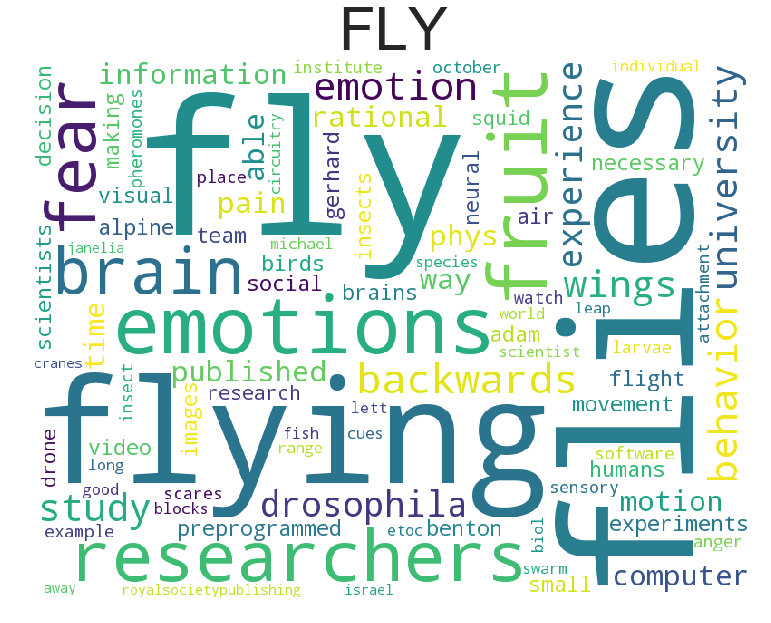

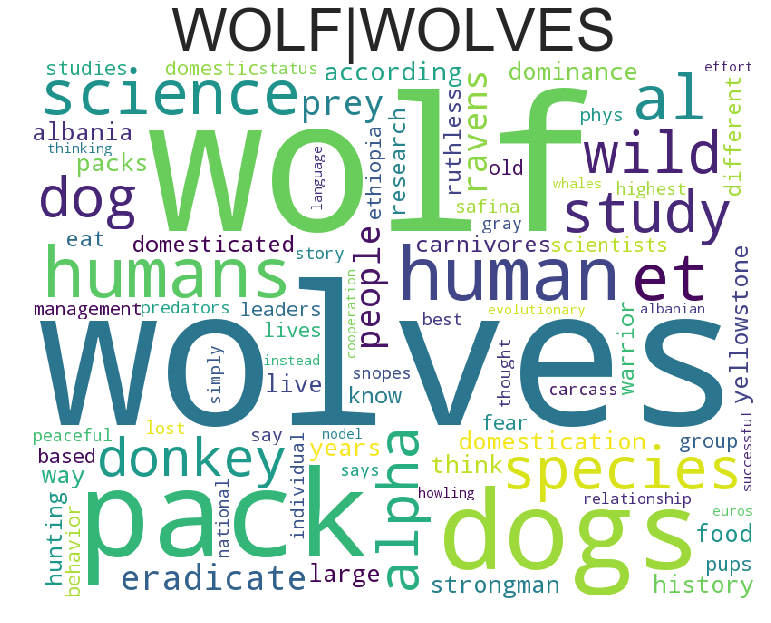

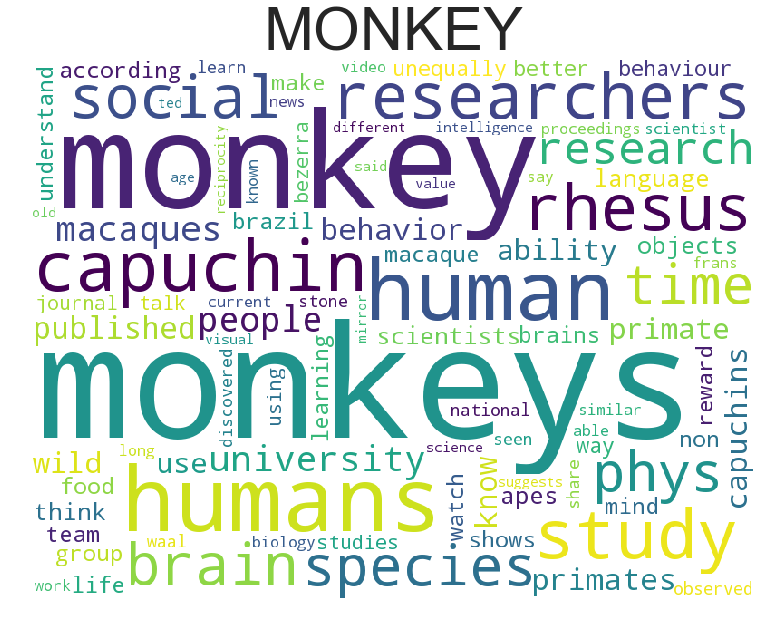

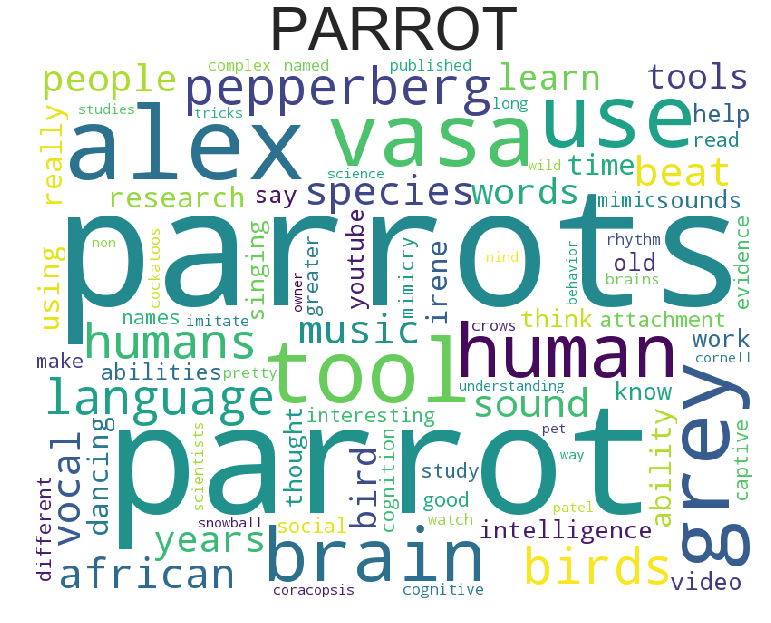

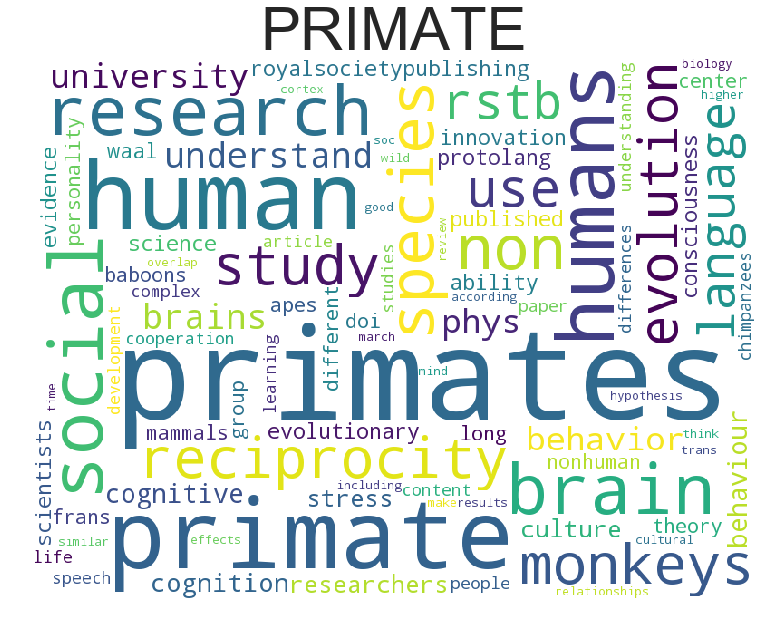

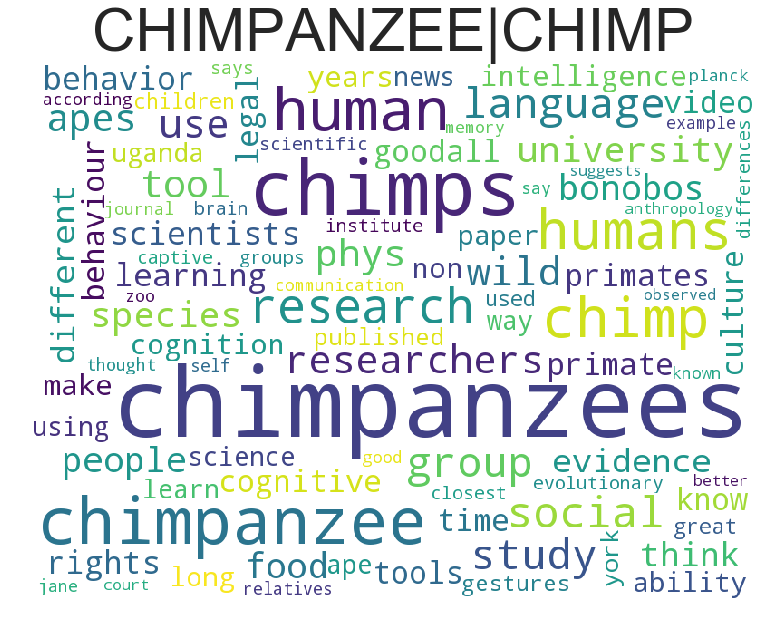

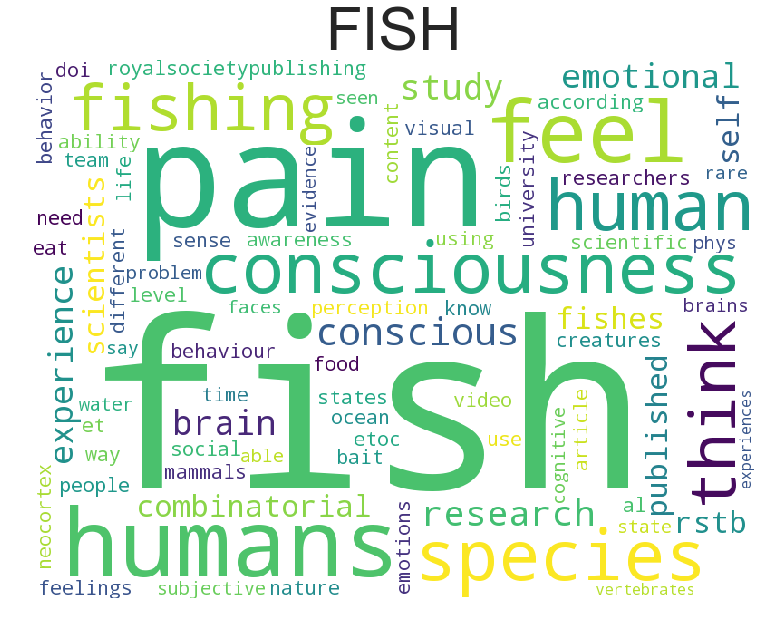

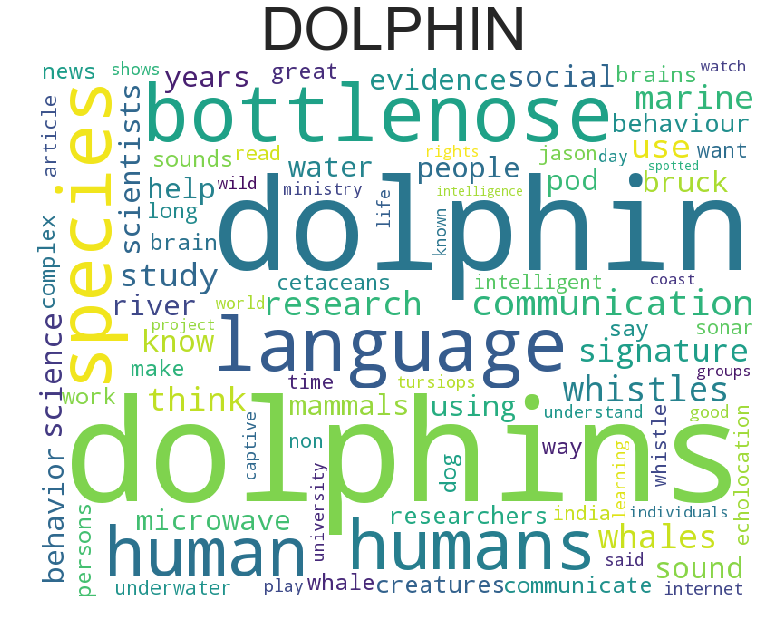

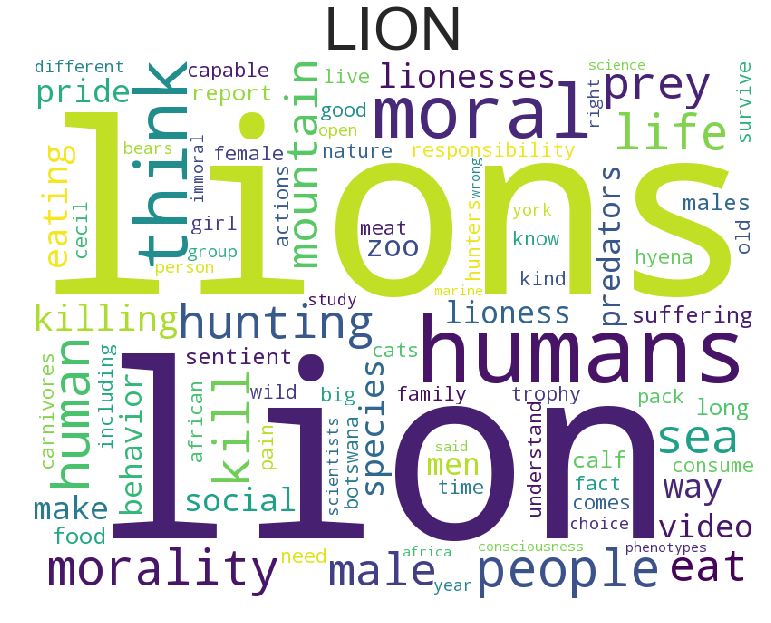

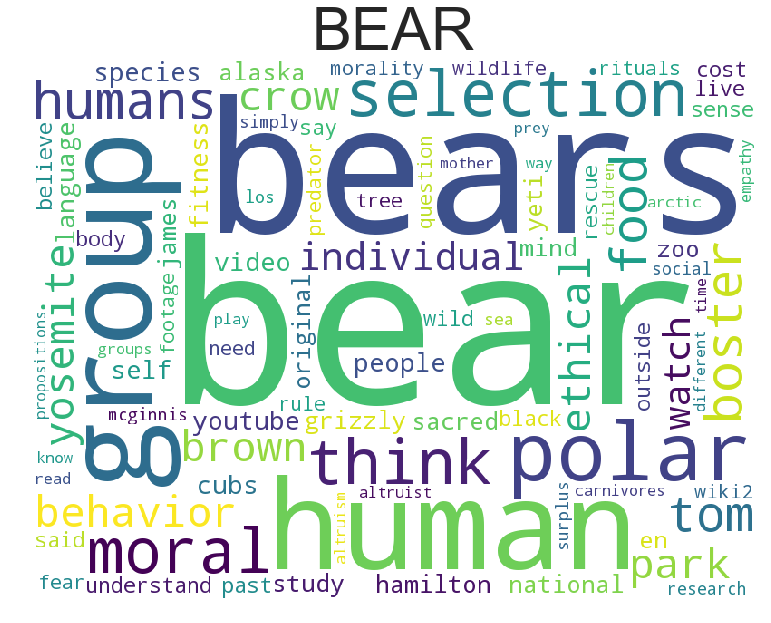

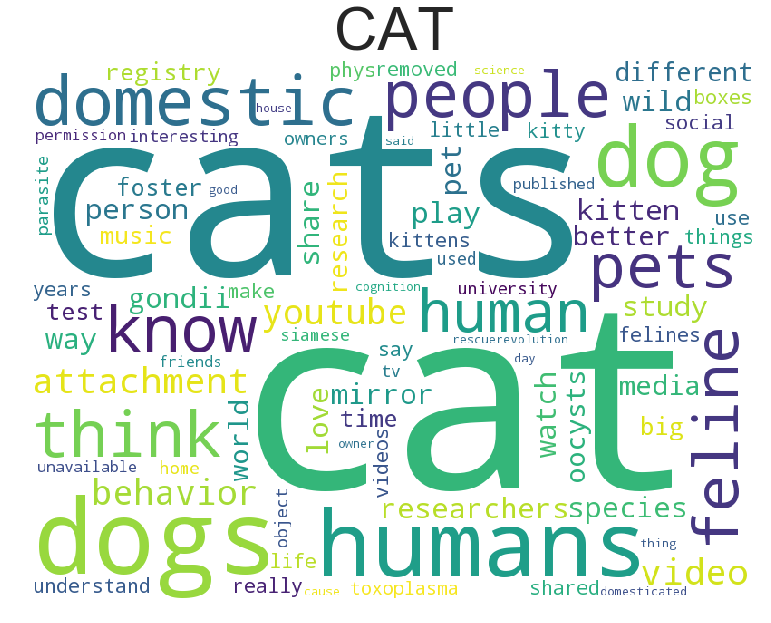

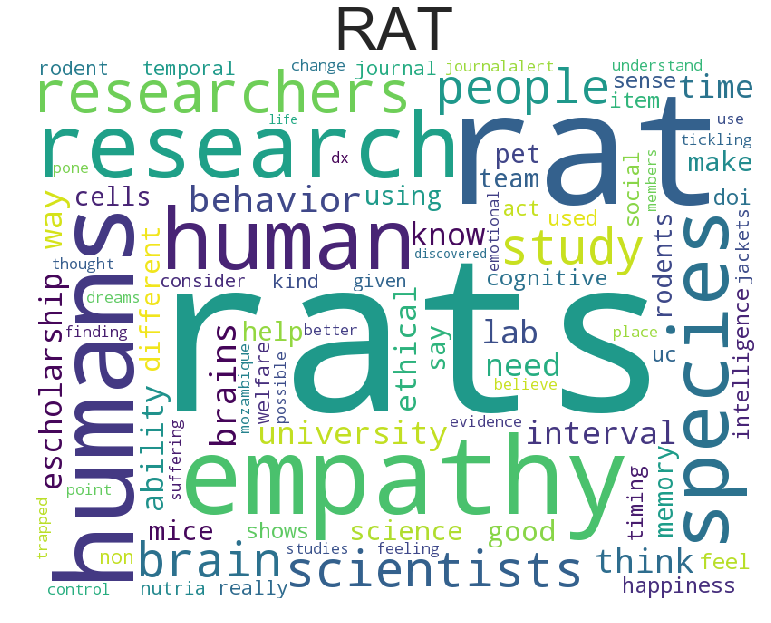

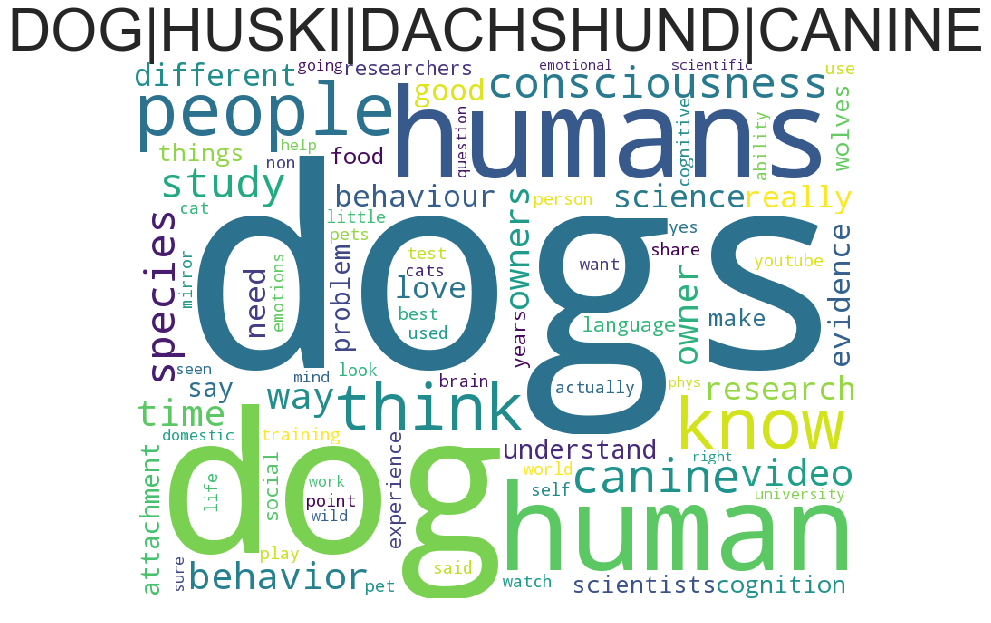

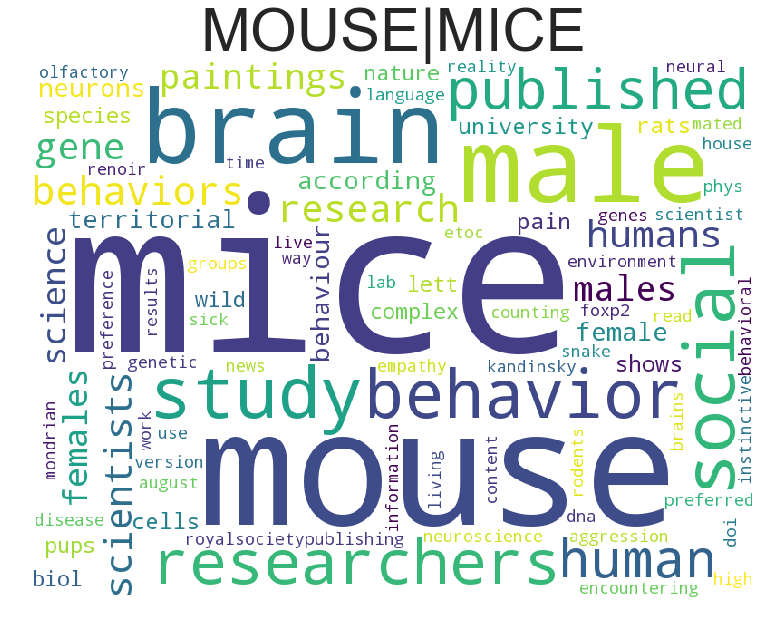

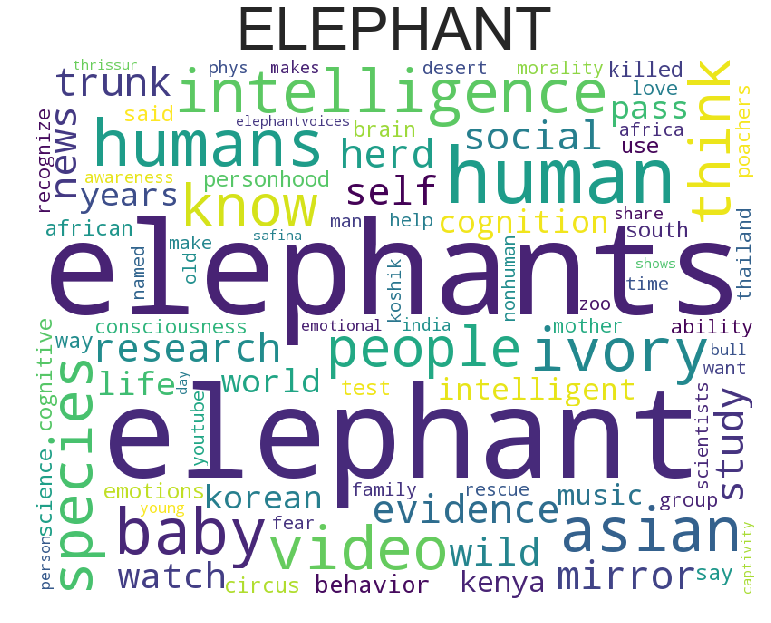

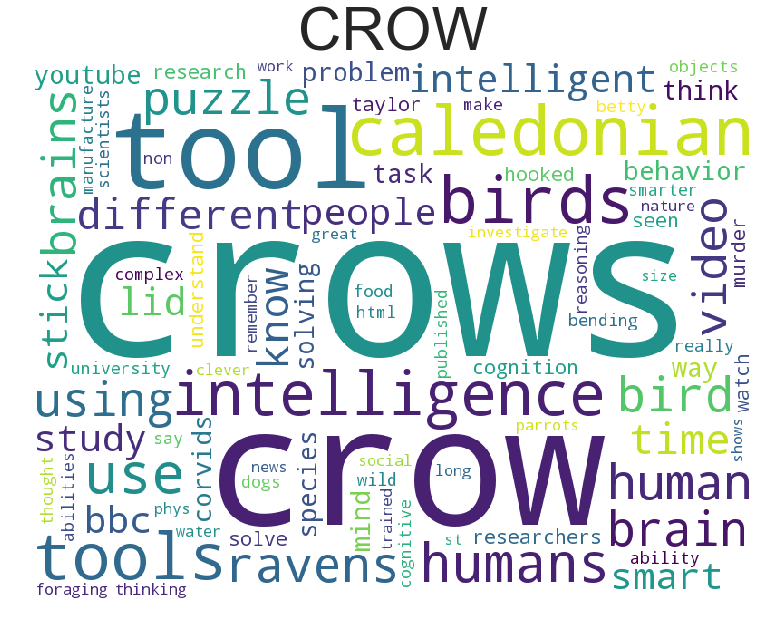

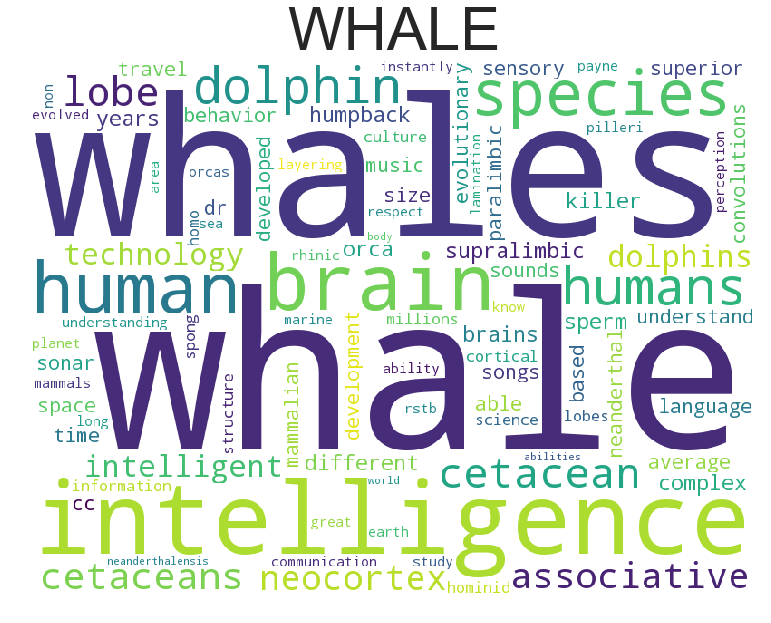

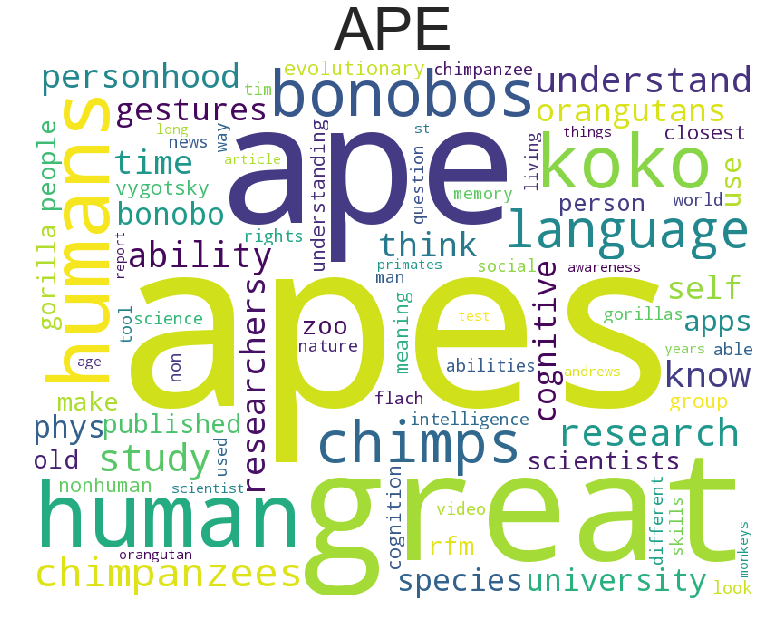

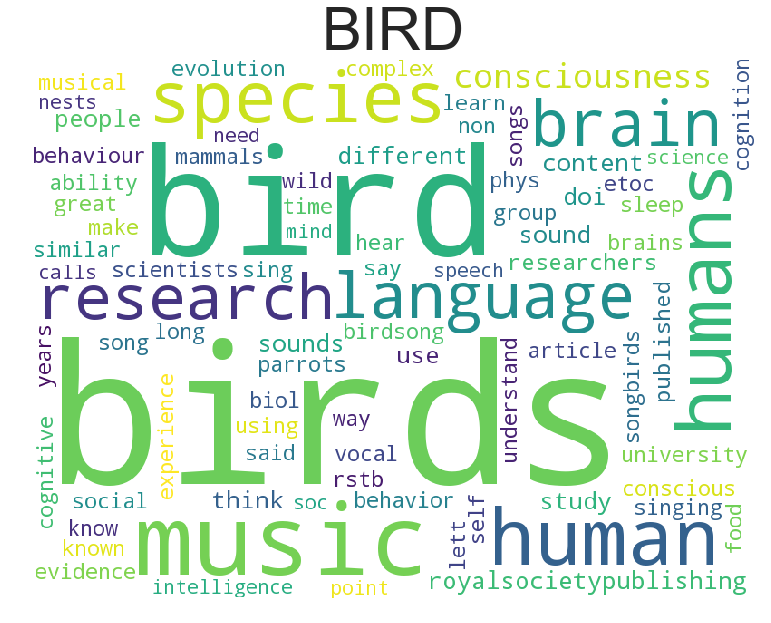

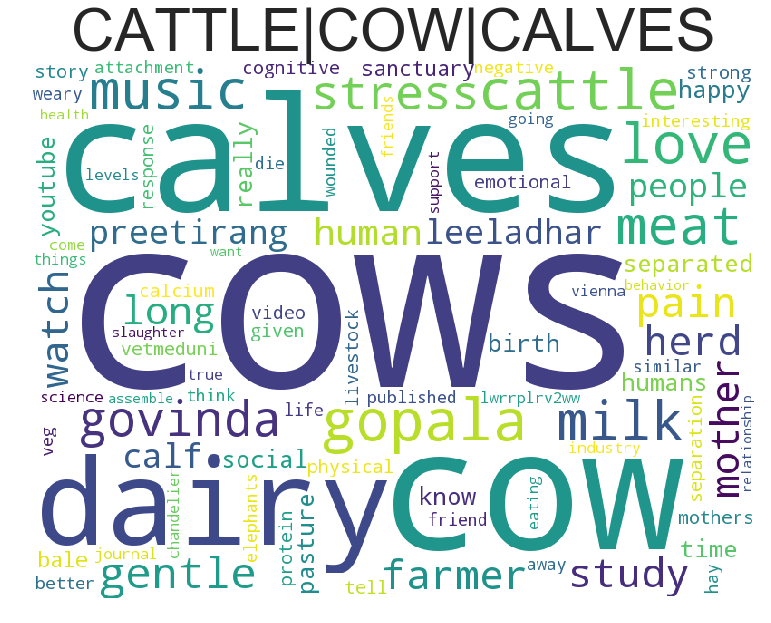

In [419]:
from wordcloud import WordCloud

for animal,words in top20animals_words.items():
#     print animal
    word_dict = {word:score for word,score in words if not unicode.isdigit(word)}
#     print 

    for sw in nltk.corpus.stopwords.words("english"):
        try:
            word_dict.pop(sw)
        except:
            pass
    for sw in set(['com','www','http','https','like','animal','animals','org','now','new','rsbl']):
        try:
            word_dict.pop(sw)
        except:
            pass
    
    
    wc = WordCloud(width=800,height=600,
                   background_color="white",
                   normalize_plurals=True)
    wc.generate_from_frequencies(word_dict)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(animal.upper(),fontsize=60)
#     plt.savefig(animal.split("|")[0]+'.png')

    plt.figure()
#     plt.savefig(animal.split("|")[0]+'.png')
    plt.show()

Plenty of interesting things appeared in the wordclouds ( tf-idf visualisations). 
Some worth noting:
* Almost all wordclouds had the words "human", "humans","people", indicating anthropocentrism, in the sense that we compare everything other animals do to us.
* In Parrot, the names Alex and Pepperberg. Alex was an African Gray parrot that could answer and ask questions in English, count, and tell the difference between several types of objects. He was trained by Irene Pepperberg.
* In Fly, it can be seen that the word is related to both the insect(and the other insect:fruit flies), but also to birds due to the double meaning of the word.
* In Rat, one of the highest ranking words is "empathy", indicating what lots of studies have shown. There's also "ethical", "scientists", "research", which are related to them being used in the science lab. However, as the Hitchhiker's Guide tells us, they are actually studying us, hence all the science related words.
* In Elephant, one of the words is "mirror", which is related to elephants being able to pass the Mirror Test.
* In Crows: "puzzle", "hook", "problem solving", "tool" all indicate their incredible problem solving skills
* In Whale, interesting words are "convolutions", "culture", "neocortex", "sonar". In fact, dolphins have the largest neocortex in the whole animal kingdom (even larger than humans).
* Ape has "Koko", a gorilla that was taught American sign language. She's still alive today.

## Collocations - can we find anything useful about the groups/animals by looking at them?

* __Collocations in Animal Cognition:__

In [370]:
full_text_animal_cognition = [] #we previously used the stemmed tokens from the text, when doing the lexical dispersion

for post in posts_animal_cognition.values():
    full_text_animal_cognition += getTextTokensFromPost(post)
    
full_text_animal_cognition = nltk.Text(full_text_animal_cognition)
print full_text_animal_cognition.collocations(num=100)

phys org; http www; youtube com; https www; attachment unavailable;
royalsocietypublishing org; www youtube; attachment may; org content;
new study; rsbl royalsocietypublishing; com watch; biol lett; timeline
photos; animal cognition; non human; years ago; content etoc; doi
rsbl; lett doi; sciencemag org; new research; www facebook;
nationalgeographic com; open access; facebook com; http rsbl; tool
use; problem solving; news nationalgeographic; scientist magazine;
year old; news sciencemag; scientificamerican com; paper published;
self awareness; rsbl published; max planck; first time; scientist com;
royal society; rspb royalsocietypublishing; phil trans; decision
making; great apes; trans soc; current biology; planck institute;
newscientist com; long term; new york; rstb royalsocietypublishing;
jane goodall; facial expressions; content cpetoc; national park;
cognitive abilities; articleno title; blogs scientificamerican; media
giphy; study published; looks like; peer reviewed; nytimes

* __Collocations in Animal Cognition and Emotional Intelligence:__

In [371]:
full_text_animal_cognition_and_emotion = [] #we previously used the stemmed tokens from the text,
                                            #when doing the lexical dispersion

for post in posts_animal_cognition_and_emotion.values():
    full_text_animal_cognition_and_emotion += getTextTokensFromPost(post)
    
full_text_animal_cognition_and_emotion = nltk.Text(full_text_animal_cognition_and_emotion)
print full_text_animal_cognition_and_emotion.collocations(num=100)

http www; https www; www facebook; facebook com; youtube com; timeline
photos; attachment unavailable; nationalgeographic com; year old; bbc
com; news nationalgeographic; attachment may; united states; national
park; www youtube; killer whales; thedodo com; animal welfare; com
watch; yahoo com; endangered species; new york; nytimes com; audubon
org; years ago; first time; www bbc; animals pass; huffingtonpost com;
humane society; news yahoo; san diego; new zealand; new study; south
africa; marine mammal; humpback whales; jane goodall; humpback whale;
killer whale; marine mammals; type theater; http news; photos type;
climate change; com news; national geographic; earth story; wild
horses; polar bear; theguardian com; animal cognition; beluga whales;
georgia aquarium; wildlife service; onegreenplanet org; http bit;
costa rica; critically endangered; sea turtle; sri lanka; san
francisco; animal rights; pit bull; bottlenose dolphins; good article;
last week; monterey bay; polar bears; mar

* __Collocations in Anthrozoology:__

In [372]:
full_text_anthrozoology = [] #we previously used the stemmed tokens from the text, when doing the lexical dispersion

for post in posts_anthrozoology.values():
    full_text_anthrozoology += getTextTokensFromPost(post)
    
full_text_anthrozoology = nltk.Text(full_text_anthrozoology)
print full_text_anthrozoology.collocations(num=100)

http www; elanimalinvisible blogspot; mafa elanimalinvisible; https
www; blogspot com; fotograf simulacro; los animales; human animal;
mafa albor; albor fotograf; art stica; animales antrozoolog; simulacro
arte; stica por; animal studies; antrozoolog art; attachment
unavailable; perseguir las; las palabras; las sombras; arte zoolog;
por mafa; youtube com; genes las; timeline photos; ciencia imagen;
theguardian com; fotograf filosof; arte ciencia; art sticas; years
ago; attachment may; animal invisible; imagen zoolog; zool gica; voz
del; multidisciplinar docente; diversas exposiciones; ense anzas;
artista multidisciplinar; zoolog fotograf; non human; naturalista
siempre; divulgaci zool; gica naturalista; sticas doctor; new zealand;
animal welfare; con experiencias; climate change; facebook com; www
facebook; animal rights; www youtube; del dise; mundo del; siempre
por; anzas art; nytimes com; year old; http mafa; com watch; imagen
con; new york; defender radio; dedicado difundir; artist

* Some of the collocations turned out to be expressions that are very relevant to animal cognition and the way people feel and talk about animals such as:

   * non human
   * first time
   * facial expressions
   * animal cognition 
   * decision making
   * problem solving
   * self awareness
   * great apes
   * current biology
   * nonhuman animals
   * cognitive abilities
   * mirror test
   * nervous system
   * feel pain
   * animal behaviour
   * best friend
   * climate change
   * wildlife service
   * critically endangered
   * sea turtle
   * good article
   * animal rights
   * intellectual lives

* Some other types of collocations showed that a lot of people research what they are posting about and talk about relevant sources:

   * scientist magazine
   * paper published
   * previously thought
   * study finds
   * scientific american
   * state university
   * peer reviewed

# Sentiment analysis

* __Sentiment analysis of post text__
    * We would like to find out what is the general attitute towards animal intelligence and whether the 3 groups differ. 
    * We would also would like to find out whether some animals bring more happiness than others. For this we look at the text of the post nodes which are connected to the animal nodes

 The LabMT 1.0. (_ ‘language assessment by Mechanical Turk 1.0’_) list was created with the use of Amazon Mechanical Turk, which is a crowdsourcing service that provides 'human intelligence'. The top 5000 most frequent words from 4 sources (Twitter, Google Books, music lyrics, and the New York Times) were merged in a set of 10 222 words. These words were rated by users of Amazon Mechanical Turk, based on their _average happiness_. 

In [6]:
f = io.open('journals.plos.org.txt','r')
lines1 = [line.rstrip('\n') for line in f] #reading all the lines in a list
lines = lines1[4:] #getting rid of the useless info, like the table headers, etc.

We are formatting the text in the txt document of the word list, with the use of regex, by creating a dictionary such that:

* __key__ -> the word

* __value__ -> happiness average, a value between 1 and 9


The attributes of each word are formatted like this:

* happiness rank 
* happiness average
* happiness standard deviation
* twitter rank 
* google rank
* nyt rank
* lyrics rank

From this we will only require `attributes[1]`, the happiness average.

In [7]:
word_list_temp = {}
for line in lines:
    word = re.findall('.*?[^\\t]*',line)
    attributes = re.findall('(\d+(?:\.\d*)?|\.\d+)|--',line) 
    word_list_temp.update({word[0]: attributes[1]})

bad_keys = {}
for k,v in word_list_temp.iteritems():
    if (float(v) > 9):
        bad_keys.update({k:v})


word_list = {key: word_list_temp[key] for key in word_list_temp.keys() if key not in bad_keys.keys()}

In [8]:
def sentiment(tokens):
    problem = 1; #if no words from the post are found in the word list
    sent = 0;
    found_tokens = 0;

    for token in tokens:
        if (token in word_list.keys()):
            problem = 0;
            found_tokens = found_tokens + 1
            sent = sent + float(word_list[token])

            
    if (problem): 
         return 0
    
    sentiment_of_text = sent / found_tokens    
    return sentiment_of_text

In [9]:
posts_animal_cognition = pickle.load(open("all_posts_animal_cognition_updated"+'.pkl', 'rb'))
posts_animal_cognition_and_emotion = pickle.load(open("all_posts_animal_cognition_and_emotion_updated"+'.pkl', 'rb'))
posts_anthrozoology = pickle.load(open("all_posts_anthrozoology_updated"+'.pkl', 'rb'))

In [11]:
tokens_animal_cognition = []
tokens_animal_cognition_and_emotion = []
tokens_anthrozoology = []

posts_sentiment_animal_cognition = {}
posts_sentiment_animal_cognition_and_emotion = {}
posts_sentiment_anthrozoology = {}

We then compute the sentiment for each posts and making a dictionary with post ID as key and sentiment as value

In [17]:
for ID, post in posts_animal_cognition.items():
    sent = sentiment(getTextTokensFromPost(post))
    posts_sentiment_animal_cognition.update({ID: sent})
    
for ID, post in posts_animal_cognition_and_emotion.items():
    sent = sentiment(getTextTokensFromPost(post))
    posts_sentiment_animal_cognition_and_emotion.update({ID: sent})
    
for ID, post in posts_anthrozoology.items():
    sent = sentiment(getTextTokensFromPost(post))
    posts_sentiment_anthrozoology.update({ID: sent})

And add a _'sentiment'_ key to the original lists with the sentiment value of each post

In [18]:
for ID, sent in posts_sentiment_animal_cognition.items():
    posts_animal_cognition[ID].update({'sentiment': sent})
    
for ID, sent in posts_sentiment_animal_cognition_and_emotion.items():
    posts_animal_cognition_and_emotion[ID].update({'sentiment': sent})
    
for ID, sent in posts_sentiment_anthrozoology.items():
    posts_anthrozoology[ID].update({'sentiment': sent})
    
    
pickle.dump(posts_animal_cognition, open("all_posts_animal_cognition_with_sentiment.pkl", "wb"))
pickle.dump(posts_animal_cognition_and_emotion, open("all_posts_animal_cognition_and_emotion_with_sentiment.pkl", "wb"))
pickle.dump(posts_anthrozoology, open("all_posts_anthrozoology_with_sentiment.pkl", "wb"))

Finally, calculate the average happiness of every group

In [19]:
len_animal_cognition = len([x for x in posts_sentiment_animal_cognition.values() if x != 0 ])
len_animal_cognition_and_emotion = len([x for x in posts_sentiment_animal_cognition_and_emotion.values() if x != 0 ])
len_anthrozoology = len([x for x in posts_sentiment_anthrozoology.values() if x != 0 ])

average_happiness_animal_cognition = sum(posts_sentiment_animal_cognition.values())/len_animal_cognition
average_happiness_animal_cognition_and_emotion = sum(posts_sentiment_animal_cognition_and_emotion.values())/len_animal_cognition_and_emotion
average_happiness_anthrozoology = sum(posts_sentiment_anthrozoology.values())/len_anthrozoology

print average_happiness_animal_cognition, min(posts_sentiment_animal_cognition.values()), max(posts_sentiment_animal_cognition.values())
print average_happiness_animal_cognition_and_emotion,  min(posts_sentiment_animal_cognition_and_emotion.values()),  max(posts_sentiment_animal_cognition_and_emotion.values())
print average_happiness_anthrozoology, min(posts_sentiment_anthrozoology.values()), max(posts_sentiment_anthrozoology.values())

5.54518814266 0 7.46
5.56189498169 0 7.96
5.5083218857 0 7.68


Next, we calculate the average happiness of each animal and storing it in a dictionary 

In [22]:
#for Animal cognition:

animal_sentiment_animal_cognition = {}
for animal in list_all_animals:
    animal_sentiment_animal_cognition.update({animal: [0,0]}) # as value: a list with 2 elements: the sum of all sentiments
                                                              # and the number of posts with that animal

for ID, sent in posts_sentiment_animal_cognition.items():
    for animal in posts_animal_cognition[ID]['animals_subject']:
        animal_sentiment_animal_cognition[animal][0] += sent
        animal_sentiment_animal_cognition[animal][1] += 1

for animal in animal_sentiment_animal_cognition.keys():
    sum_of_sentiments = animal_sentiment_animal_cognition[animal][0]
    number_of_sentiments = animal_sentiment_animal_cognition[animal][1]
    if number_of_sentiments != 0:
        average_sentiment = sum_of_sentiments / number_of_sentiments
    else:
        average_sentiment = 0
    animal_sentiment_animal_cognition[animal] = average_sentiment
    
#for Animal Cognition and emotion:

animal_sentiment_animal_cognition_and_emotion = {}
for animal in list_all_animals:
    animal_sentiment_animal_cognition_and_emotion.update({animal: [0,0]}) # as value: a list with 2 elements: the sum of all sentiments
                                                              # and the number of posts with that animal

for ID, sent in posts_sentiment_animal_cognition_and_emotion.items():
    for animal in posts_animal_cognition_and_emotion[ID]['animals_subject']:
        animal_sentiment_animal_cognition_and_emotion[animal][0] += sent
        animal_sentiment_animal_cognition_and_emotion[animal][1] += 1

for animal in animal_sentiment_animal_cognition_and_emotion.keys():
    sum_of_sentiments = animal_sentiment_animal_cognition_and_emotion[animal][0]
    number_of_sentiments = animal_sentiment_animal_cognition_and_emotion[animal][1]
    if number_of_sentiments != 0:
        average_sentiment = sum_of_sentiments / number_of_sentiments
    else:
        average_sentiment = 0
    animal_sentiment_animal_cognition_and_emotion[animal] = average_sentiment
    
#for Anthrozoology:

animal_sentiment_anthrozoology = {}
for animal in list_all_animals:
    animal_sentiment_anthrozoology.update({animal: [0,0]}) # as value: a list with 2 elements: the sum of all sentiments
                                                              # and the number of posts with that animal

for ID, sent in posts_sentiment_anthrozoology.items():
    for animal in posts_anthrozoology[ID]['animals_subject']:
        animal_sentiment_anthrozoology[animal][0] += sent
        animal_sentiment_anthrozoology[animal][1] += 1

for animal in animal_sentiment_anthrozoology.keys():
    sum_of_sentiments = animal_sentiment_anthrozoology[animal][0]
    number_of_sentiments = animal_sentiment_anthrozoology[animal][1]
    if number_of_sentiments != 0:
        average_sentiment = sum_of_sentiments / number_of_sentiments
    else:
        average_sentiment = 0
    animal_sentiment_anthrozoology[animal] = average_sentiment
    

In [23]:
print max(animal_sentiment_animal_cognition.values())
print max(animal_sentiment_animal_cognition_and_emotion.values())
print max(animal_sentiment_anthrozoology.values())

7.26
6.22365888747
6.11875


In [539]:
#delete animals that don't have sentiment

for k in animal_sentiment_animal_cognition.keys():
    if (animal_sentiment_animal_cognition[k] == 0):
        del animal_sentiment_animal_cognition[k]
        
for k in animal_sentiment_animal_cognition.keys():
    if (animal_sentiment_animal_cognition[k] == 0):
        del animal_sentiment_animal_cognition[k]
        
for k in animal_sentiment_anthrozoology.keys():
    if (animal_sentiment_anthrozoology[k] == 0):
        del animal_sentiment_anthrozoology[k]

In [540]:
import operator
sorted_animal_sentiment_animal_cognition = sorted(animal_sentiment_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)
sorted_animal_sentiment_animal_cognition_and_emotion = sorted(animal_sentiment_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)
sorted_animal_sentiment_anthrozoology = sorted(animal_sentiment_anthrozoology.items(), key=operator.itemgetter(1), reverse = 1)


In [541]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
head = ['animal','happiness']

df_anthrozoology = pd.DataFrame.from_records(sorted_animal_sentiment_anthrozoology, columns = head, index=None)
df_animal_cognition = pd.DataFrame.from_records(sorted_animal_sentiment_animal_cognition, columns = head, index=None)
df_animal_cognition_and_emotion = pd.DataFrame.from_records(sorted_animal_sentiment_animal_cognition_and_emotion, columns = head, index=None)

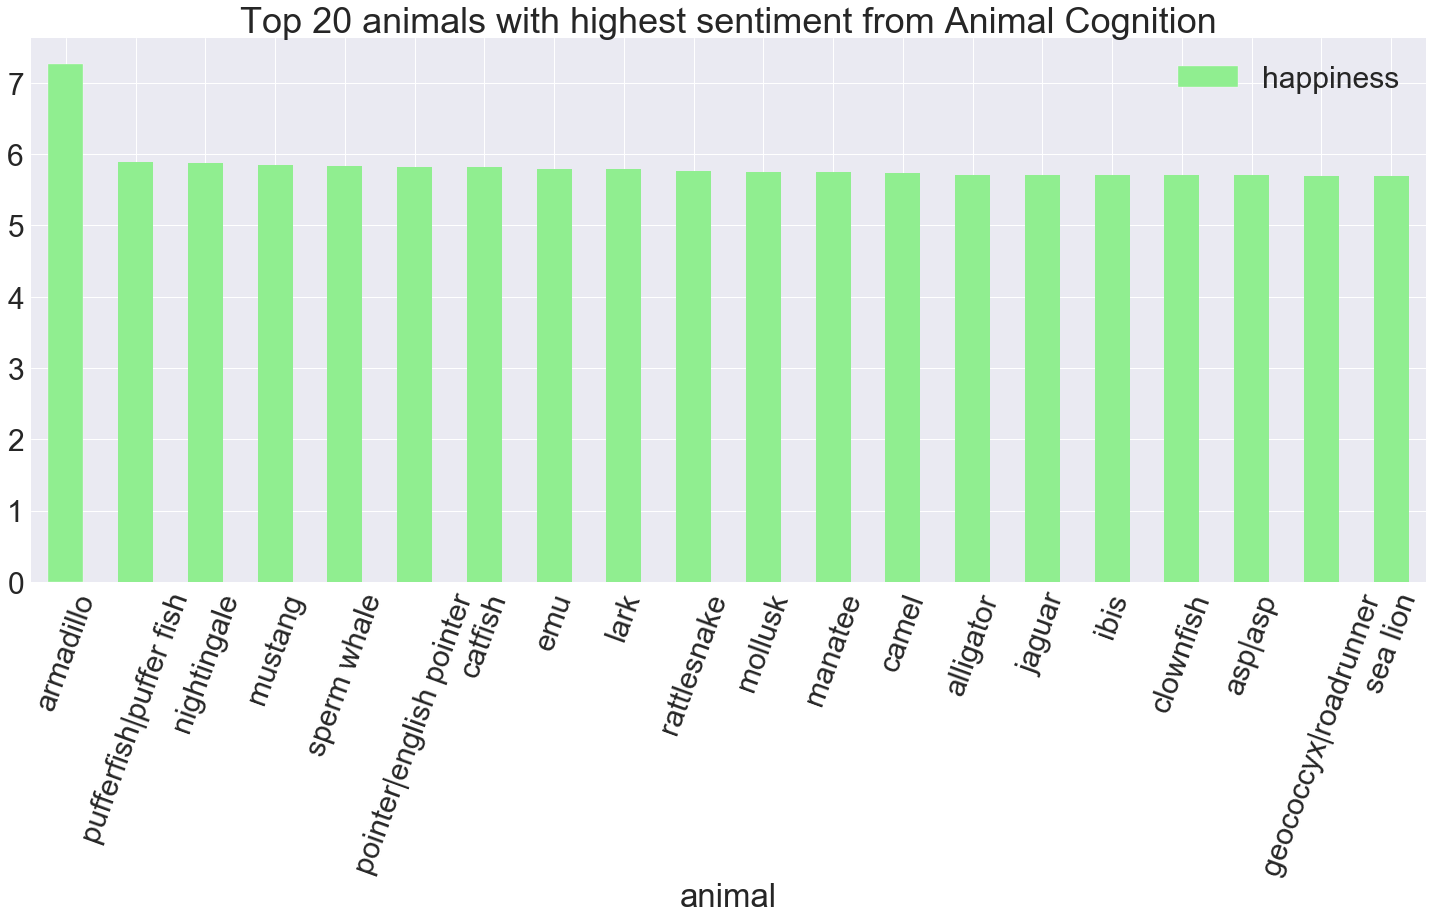

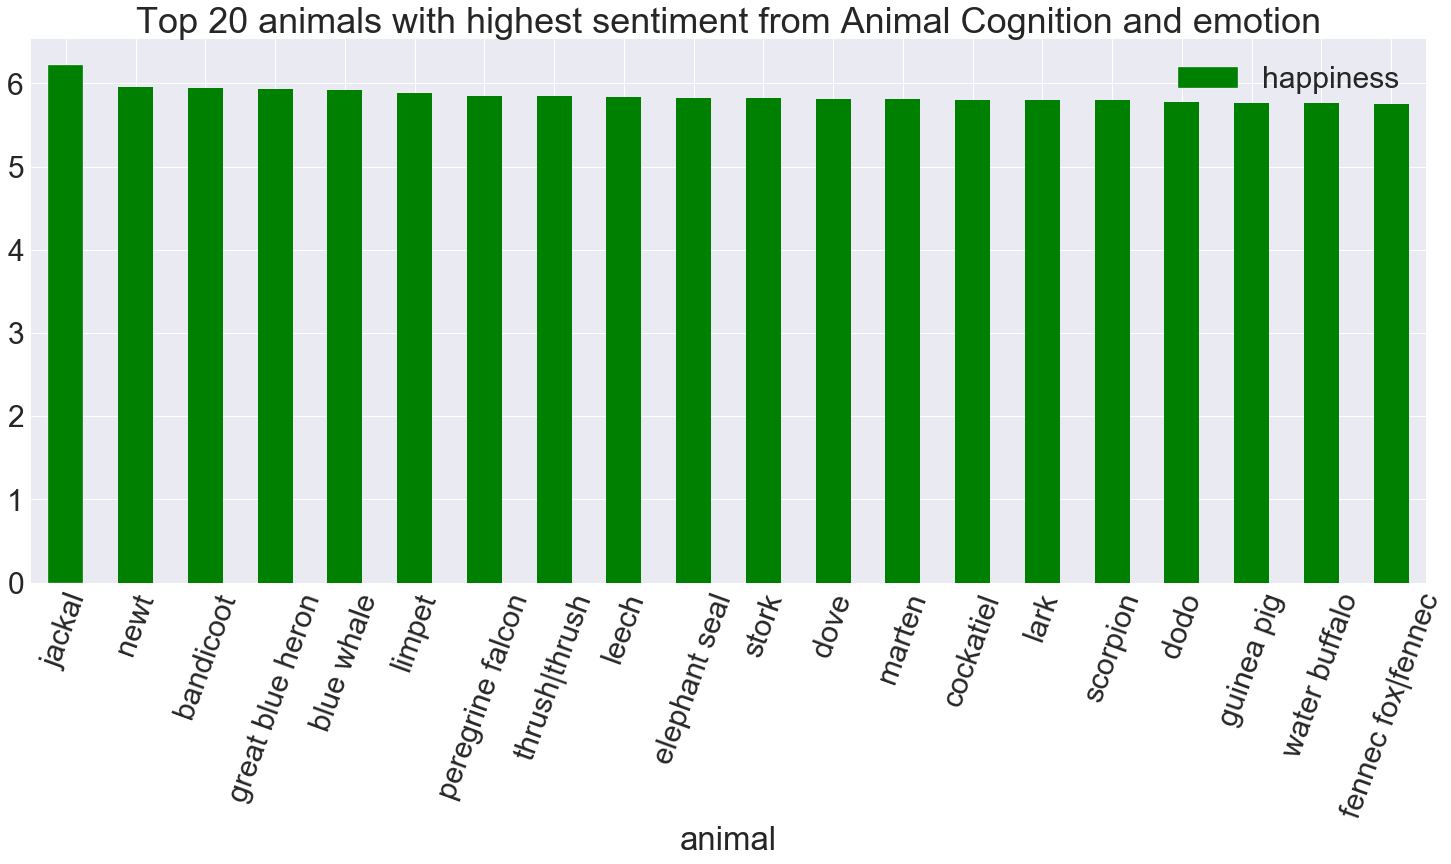

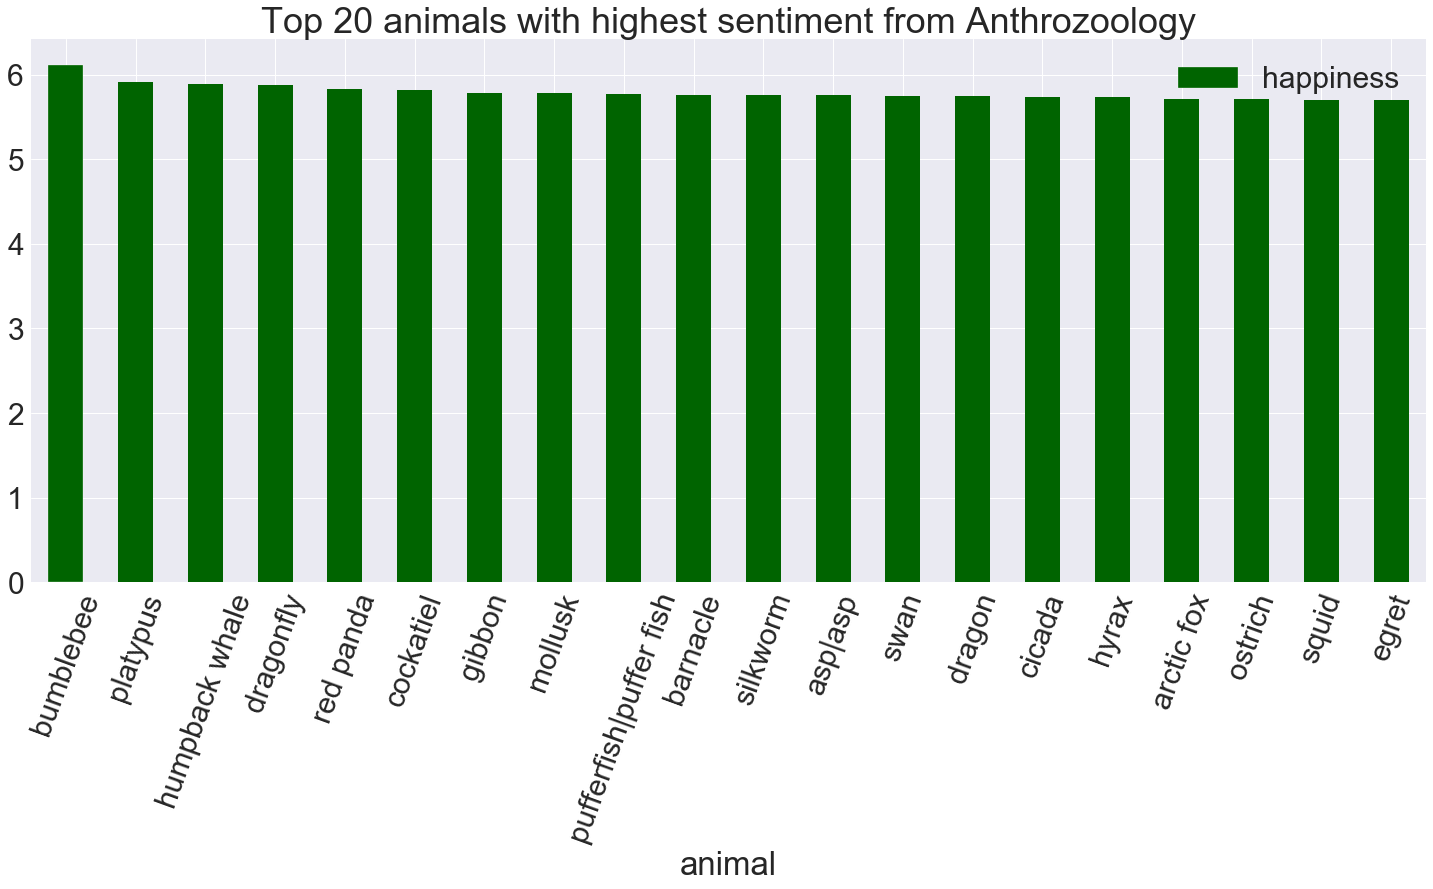

In [518]:
seaborn.set(font_scale=3)

df_animal_cognition[:20].plot('animal', kind = 'bar',subplots = False, color = ['lightgreen'], 
                    figsize = (25,10), edgecolor = 'white', title = 'Top 20 animals with highest sentiment from Animal Cognition')

plt.xticks(rotation=70)
plt.show()

df_animal_cognition_and_emotion[:20].plot('animal', kind = 'bar',subplots = False, color = ['green'], 
                    figsize = (25,10), edgecolor = 'white', 
                                          title = 'Top 20 animals with highest sentiment from Animal Cognition and emotion')
plt.xticks(rotation=70)
plt.show()

df_anthrozoology[:20].plot('animal', kind = 'bar',subplots = False, color = ['darkgreen'], 
                    figsize = (25,10), edgecolor = 'white', title = 'Top 20 animals with highest sentiment from Anthrozoology')
plt.xticks(rotation=70)
plt.show()

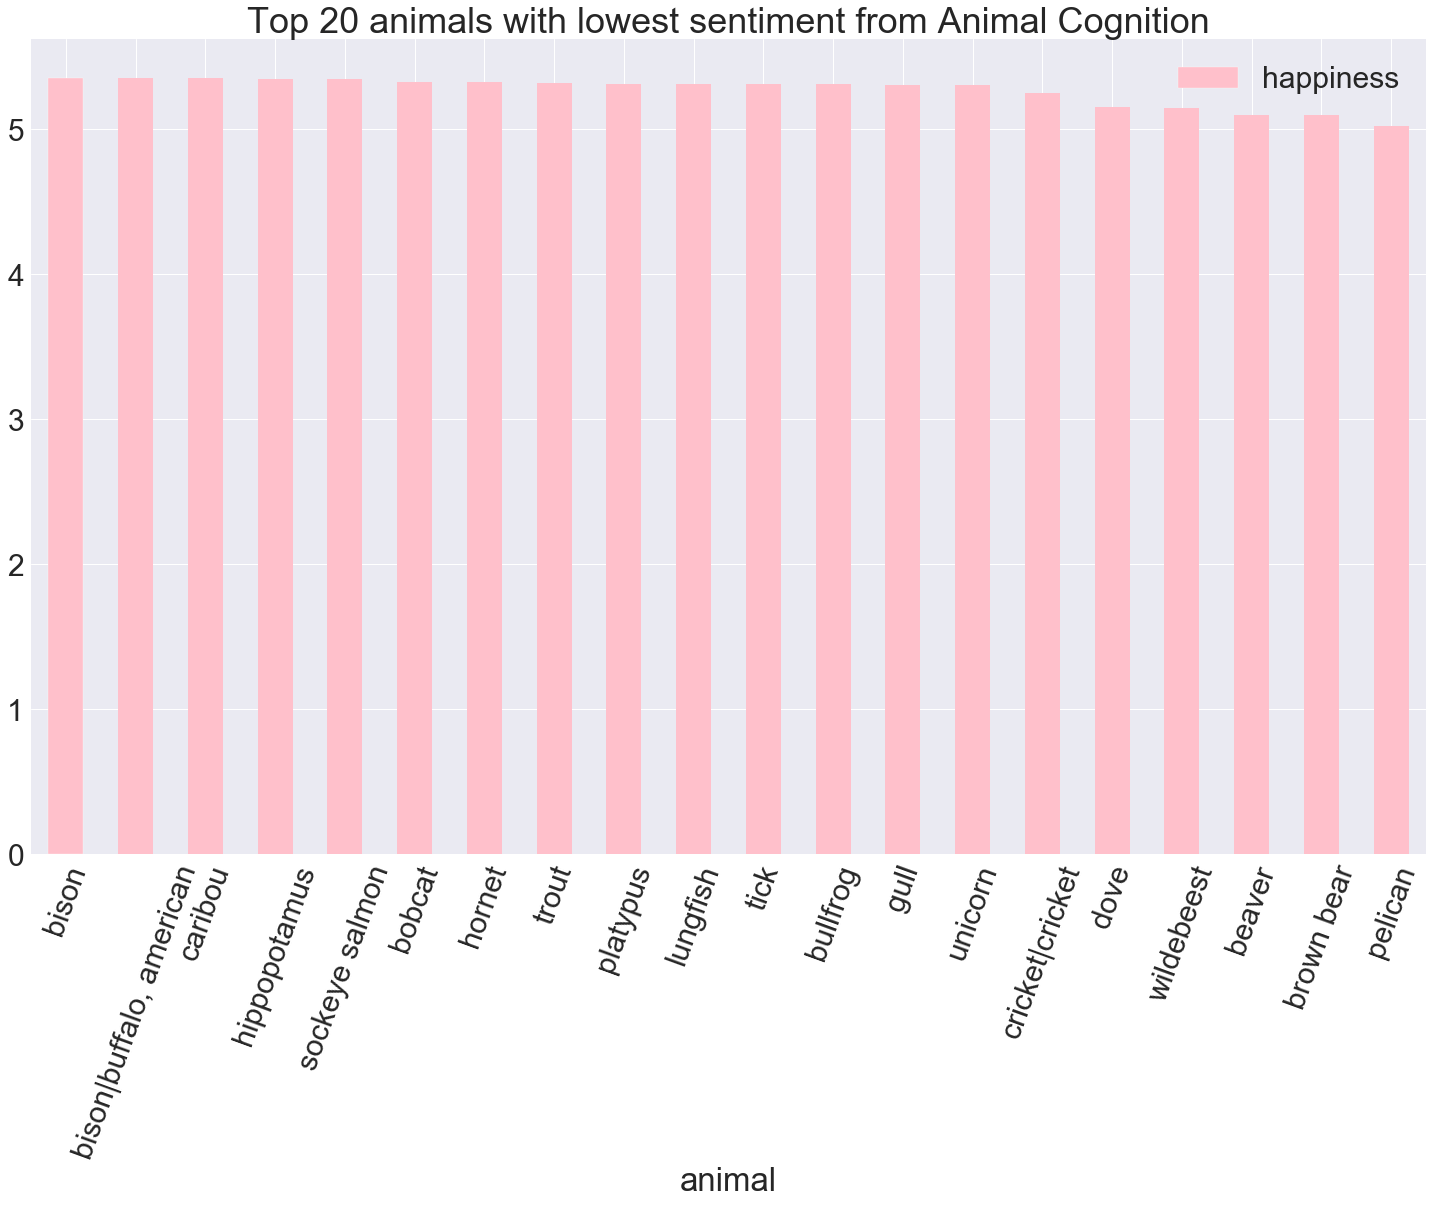

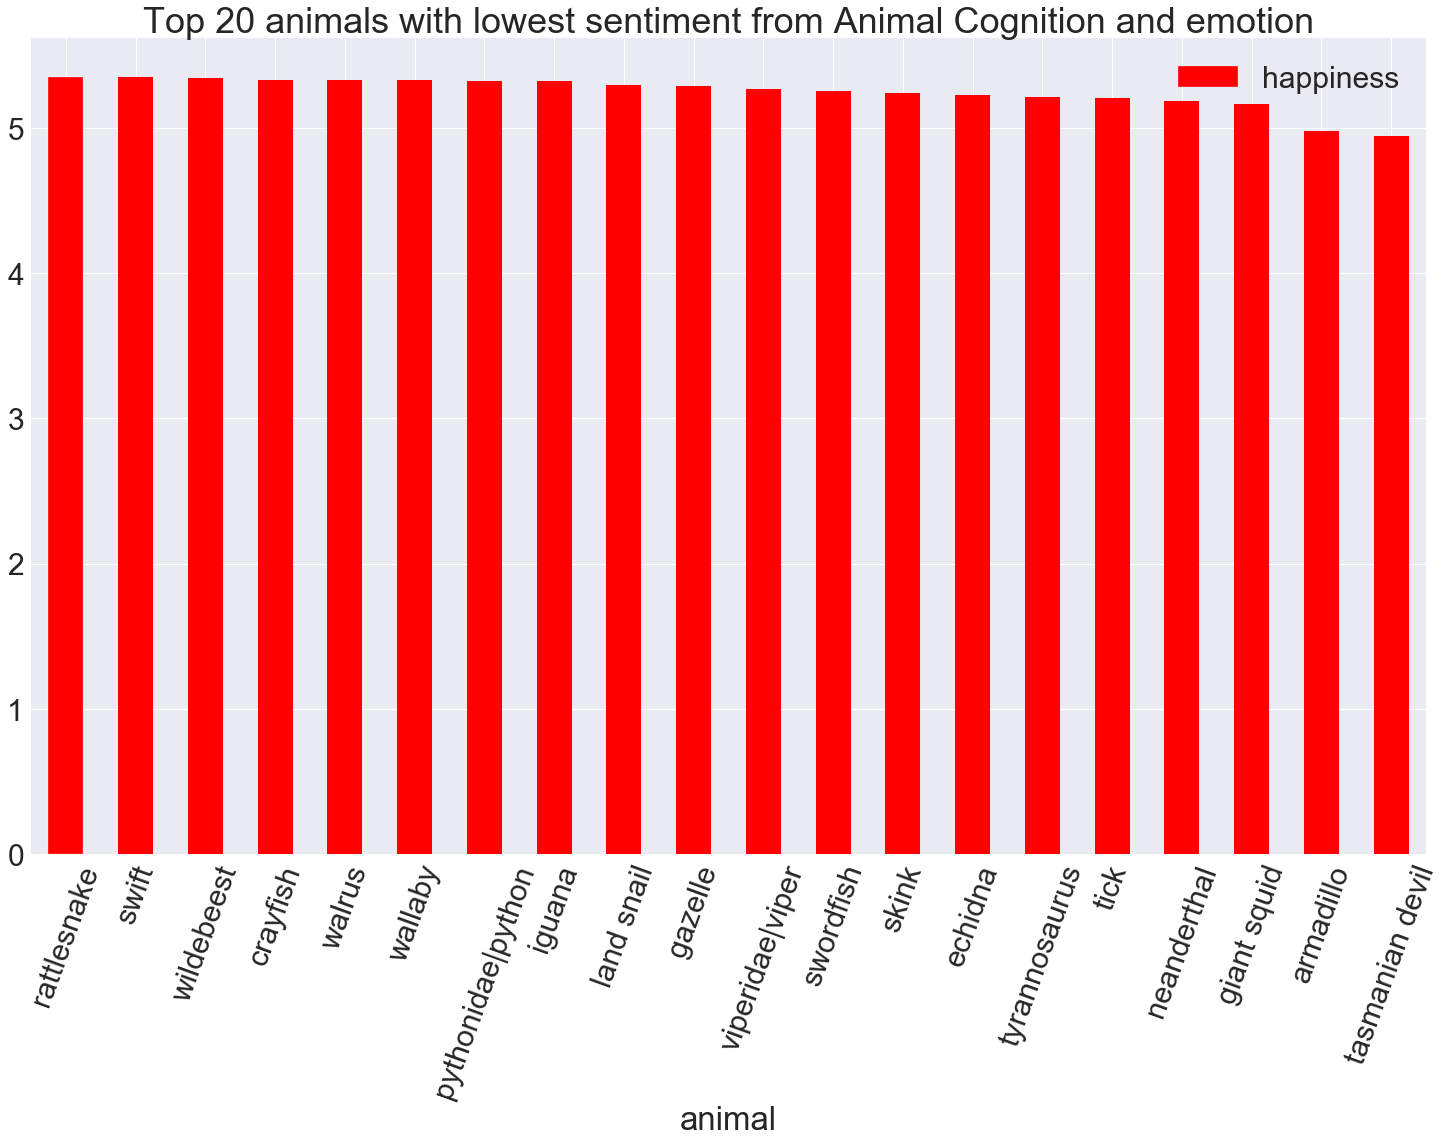

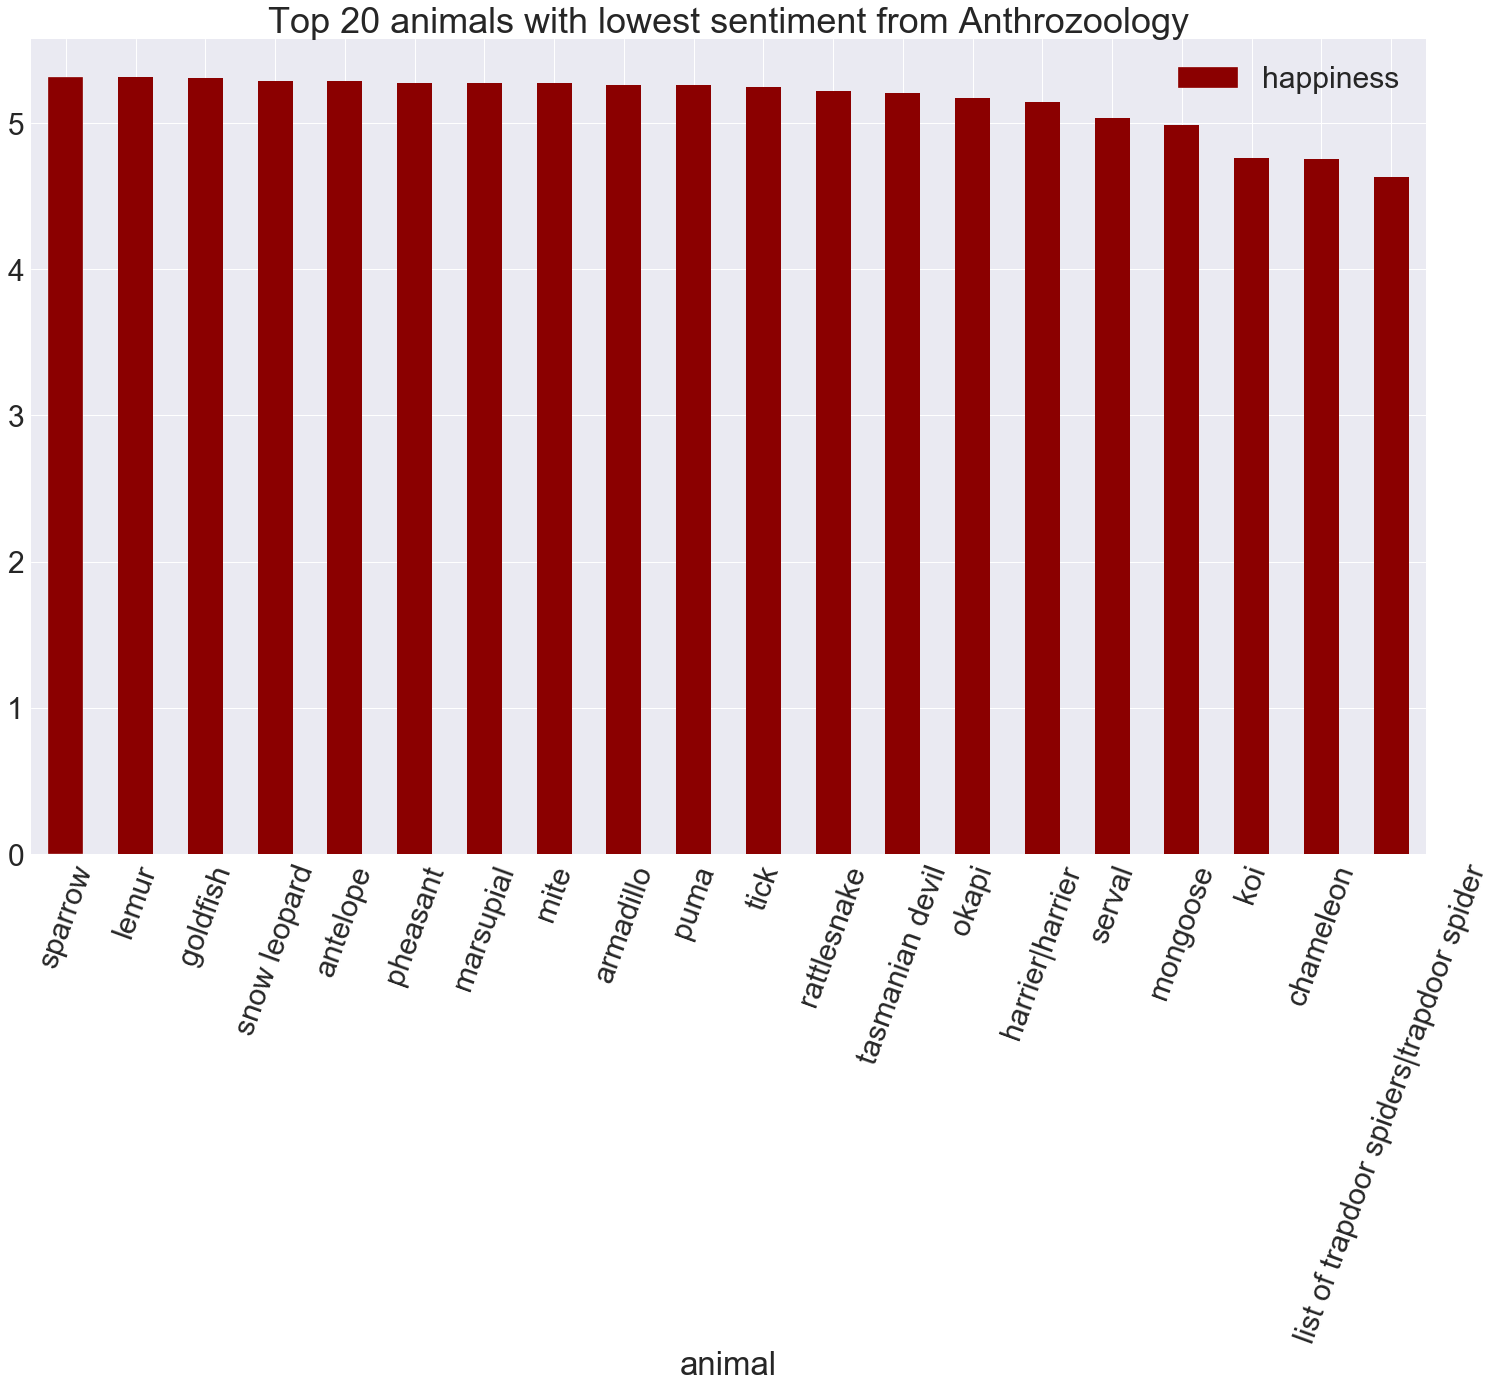

In [544]:
seaborn.set(font_scale=3)

df_animal_cognition[-20:].plot('animal', kind = 'bar',subplots = False, color = ['pink'], 
                    figsize = (25,15), edgecolor = 'white', title = 'Top 20 animals with lowest sentiment from Animal Cognition')

plt.xticks(rotation=70)
plt.show()

df_animal_cognition_and_emotion[-20:].plot('animal', kind = 'bar',subplots = False, color = ['red'], 
                    figsize = (25,15), edgecolor = 'white', 
                                          title = 'Top 20 animals with lowest sentiment from Animal Cognition and emotion')
plt.xticks(rotation=70)
plt.show()

df_anthrozoology[-20:].plot('animal', kind = 'bar',subplots = False, color = ['darkred'], 
                    figsize = (25,15), edgecolor = 'white', title = 'Top 20 animals with lowest sentiment from Anthrozoology')
plt.xticks(rotation=70)
plt.show()

# Extra
## Find the top posters in each group

In [107]:
members_animal_cognition_temp = pickle.load(open("all_members_animal_cognition"+'.pkl', 'rb'))
members_animal_cognition_and_emotion_temp = pickle.load(open("all_members_animal_cognition_and_emotion"+'.pkl', 'rb'))
members_anthrozoology_temp = pickle.load(open("all_members_anthrozoology"+'.pkl', 'rb'))

* __Top posters in Animal Cognition:__

In [114]:
members_animal_cognition = {}
for ID, member in members_animal_cognition_temp.iteritems():
    members_animal_cognition.update({ID: {'name': member, 'number_of_reactions': 0, 
                                                          'number_of_comments' : 0,
                                                          'number_of_posts'    : 0,
                                                          'total_interactions' : 0} })    

In [551]:
l=0

for ID in posts_animal_cognition.keys():
    # reactions:
    if posts_animal_cognition[ID]['reactions'] != 0:
        l = len(posts_animal_cognition[ID]['reactions']['data'])
        for i in range(l):
            member_id = posts_animal_cognition[ID]['reactions']['data'][i]['id']
            if members_animal_cognition.has_key(member_id):
                members_animal_cognition[member_id]['number_of_reactions'] += 1
    # posted_by:
    member_id = posts_animal_cognition[ID]['from']['id']
    if members_animal_cognition.has_key(member_id):
        members_animal_cognition[member_id]['number_of_posts'] += 1
    # first level comments:
    all_comments = getComments_2(posts_animal_cognition[ID])    
    if (all_comments != 0):
        for i in range(len(all_comments)):
            if (all_comments[i].has_key('from')):             
                member_id = all_comments[i]['from']['id']
                if members_animal_cognition.has_key(member_id):
                    members_animal_cognition[member_id]['number_of_comments'] +=1
        # second level comments:
            if (all_comments[i].has_key('comments')):
                for j in range (len(all_comments[i]['comments']['data'])):
                    if (all_comments[i]['comments']['data'][j].has_key('from')):                                              
                        this_id = all_comments[i]['comments']['data'][j]['from']['id']
                        if members_animal_cognition.has_key(this_id):
                            members_animal_cognition[this_id]['number_of_comments'] += 1
                            
for ID in members_animal_cognition.keys():
    members_animal_cognition[ID]['total_interactions'] = members_animal_cognition[ID]['number_of_reactions'] + members_animal_cognition[ID]['number_of_comments'] + members_animal_cognition[ID]['number_of_posts']        

In [554]:
members_reactions_animal_cognition = {ID: members_animal_cognition[ID]['number_of_reactions'] for ID in members_animal_cognition.keys() }
sorted_members_reactions_animal_cognition = sorted(members_reactions_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)
id_most_reactions_animal_cognition = sorted_members_reactions_animal_cognition[0][0]
member_with_most_reactions_animal_cognition = members_animal_cognition[id_most_reactions_animal_cognition]

members_comments_animal_cognition = {ID: members_animal_cognition[ID]['number_of_comments'] for ID in members_animal_cognition.keys() }
sorted_members_comments_animal_cognition = sorted(members_comments_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)
id_most_comments_animal_cognition = sorted_members_reactions_animal_cognition[0][0]
member_with_most_comments_animal_cognition = members_animal_cognition[id_most_comments_animal_cognition]

members_posts_animal_cognition = {ID: members_animal_cognition[ID]['number_of_posts'] for ID in members_animal_cognition.keys() }
sorted_members_posts_animal_cognition = sorted(members_posts_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)
id_most_posts_animal_cognition = sorted_members_posts_animal_cognition[0][0]
member_with_most_posts_animal_cognition = members_animal_cognition[id_most_posts_animal_cognition]

members_interactions_animal_cognition = {ID: members_animal_cognition[ID]['total_interactions'] for ID in members_animal_cognition.keys() }
sorted_members_interactions_animal_cognition = sorted(members_interactions_animal_cognition.items(), key=operator.itemgetter(1), reverse = 1)
id_most_interactions_animal_cognition = sorted_members_interactions_animal_cognition[0][0]
member_with_most_interactions_animal_cognition = members_animal_cognition[id_most_interactions_animal_cognition]


print "\n Most reactions: \n", member_with_most_reactions_animal_cognition
print "\n Most comments: \n", member_with_most_comments_animal_cognition
print "\n Most posts: \n", member_with_most_posts_animal_cognition
print "\n Most interactions: \n", member_with_most_interactions_animal_cognition






 Most reactions: 
{'number_of_comments': 28, 'number_of_posts': 366, 'total_interactions': 3280, 'name': u'Dmitri Kaminiar', 'number_of_reactions': 2886}

 Most comments: 
{'number_of_comments': 1120, 'number_of_posts': 3070, 'total_interactions': 4210, 'name': u'Robert Karl Stonjek', 'number_of_reactions': 20}

 Most posts: 
{'number_of_comments': 1120, 'number_of_posts': 3070, 'total_interactions': 4210, 'name': u'Robert Karl Stonjek', 'number_of_reactions': 20}

 Most interactions: 
{'number_of_comments': 1120, 'number_of_posts': 3070, 'total_interactions': 4210, 'name': u'Robert Karl Stonjek', 'number_of_reactions': 20}


* __Top posters in Animal Cognition and emotional intelligence:__

In [117]:
members_animal_cognition_and_emotion = {}
for ID, member in members_animal_cognition_and_emotion_temp.iteritems():
    members_animal_cognition_and_emotion.update({ID: {'name': member, 'number_of_reactions': 0, 
                                                          'number_of_comments' : 0,
                                                          'number_of_posts'    : 0,
                                                          'total_interactions' : 0} })    

In [154]:
l=0

for ID in posts_animal_cognition_and_emotion.keys():
    # reactions:
    if posts_animal_cognition_and_emotion[ID]['reactions'] != 0:
        l = len(posts_animal_cognition_and_emotion[ID]['reactions']['data'])
        for i in range(l):
            member_id = posts_animal_cognition_and_emotion[ID]['reactions']['data'][i]['id']
            if members_animal_cognition_and_emotion.has_key(member_id):
                members_animal_cognition_and_emotion[member_id]['number_of_reactions'] += 1
    # posted_by:
    member_id = posts_animal_cognition_and_emotion[ID]['from']['id']
    if members_animal_cognition_and_emotion.has_key(member_id):
        members_animal_cognition_and_emotion[member_id]['number_of_posts'] += 1
    # first level comments:
    all_comments = getComments(posts_animal_cognition_and_emotion[ID])    
    if (all_comments != None):
        for i in range(len(all_comments)):
            if (all_comments[i].has_key('from')):             
                member_id = all_comments[i]['from']['id']
                if members_animal_cognition_and_emotion.has_key(member_id):
                    members_animal_cognition_and_emotion[member_id]['number_of_comments'] +=1
        # second level comments:
            if (all_comments[i].has_key('comments')):
                for j in range (len(all_comments[i]['comments']['data'])):
                    if (all_comments[i]['comments']['data'][j].has_key('from')):                                              
                        this_id = all_comments[i]['comments']['data'][j]['from']['id']
                        if members_animal_cognition_and_emotion.has_key(this_id):
                            members_animal_cognition_and_emotion[this_id]['number_of_comments'] += 1
                            
for ID in members_animal_cognition_and_emotion.keys():
    members_animal_cognition_and_emotion[ID]['total_interactions'] = members_animal_cognition_and_emotion[ID]['number_of_reactions'] + members_animal_cognition_and_emotion[ID]['number_of_comments'] + members_animal_cognition_and_emotion[ID]['number_of_posts']        

In [549]:
members_reactions_animal_cognition_and_emotion = {ID: members_animal_cognition_and_emotion[ID]['number_of_reactions'] for ID in members_animal_cognition_and_emotion.keys() }
sorted_members_reactions_animal_cognition_and_emotion = sorted(members_reactions_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)
id_most_reactions_animal_cognition_and_emotion = sorted_members_reactions_animal_cognition_and_emotion[0][0]
member_with_most_reactions_animal_cognition_and_emotion = members_animal_cognition_and_emotion[id_most_reactions_animal_cognition_and_emotion]

members_comments_animal_cognition_and_emotion = {ID: members_animal_cognition_and_emotion[ID]['number_of_comments'] for ID in members_animal_cognition_and_emotion.keys() }
sorted_members_comments_animal_cognition_and_emotion = sorted(members_comments_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)
id_most_comments_animal_cognition_and_emotion = sorted_members_comments_animal_cognition_and_emotion[0][0]
member_with_most_comments_animal_cognition_and_emotion = members_animal_cognition_and_emotion[id_most_comments_animal_cognition_and_emotion]


members_posts_animal_cognition_and_emotion = {ID: members_animal_cognition_and_emotion[ID]['number_of_posts'] for ID in members_animal_cognition_and_emotion.keys() }
sorted_members_posts_animal_cognition_and_emotion = sorted(members_posts_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)
id_most_posts_animal_cognition_and_emotion = sorted_members_posts_animal_cognition_and_emotion[0][0]
member_with_most_posts_animal_cognition_and_emotion = members_animal_cognition_and_emotion[id_most_posts_animal_cognition_and_emotion]

members_interactions_animal_cognition_and_emotion = {ID: members_animal_cognition_and_emotion[ID]['total_interactions'] for ID in members_animal_cognition_and_emotion.keys() }
sorted_members_interactions_animal_cognition_and_emotion = sorted(members_interactions_animal_cognition_and_emotion.items(), key=operator.itemgetter(1), reverse = 1)
id_most_interactions_animal_cognition_and_emotion = sorted_members_interactions_animal_cognition_and_emotion[0][0]
member_with_most_interactions_animal_cognition_and_emotion = members_animal_cognition_and_emotion[id_most_interactions_animal_cognition_and_emotion]


print "\n Most reactions: \n", member_with_most_reactions_animal_cognition_and_emotion
print "\n Most comments: \n", member_with_most_comments_animal_cognition_and_emotion
print "\n Most posts: \n", member_with_most_posts_animal_cognition_and_emotion
print "\n Most interactions: \n", member_with_most_interactions_animal_cognition_and_emotion






 Most reactions: 
{'number_of_comments': 5514, 'number_of_posts': 21555, 'total_interactions': 31128, 'name': u'Susan Freeman', 'number_of_reactions': 4059}

 Most comments: 
{'number_of_comments': 5514, 'number_of_posts': 21555, 'total_interactions': 31128, 'name': u'Susan Freeman', 'number_of_reactions': 4059}

 Most posts: 
{'number_of_comments': 5514, 'number_of_posts': 21555, 'total_interactions': 31128, 'name': u'Susan Freeman', 'number_of_reactions': 4059}

 Most interactions: 
{'number_of_comments': 5514, 'number_of_posts': 21555, 'total_interactions': 31128, 'name': u'Susan Freeman', 'number_of_reactions': 4059}


* __Top posters in Anthrozoology:__

In [132]:
members_anthrozoology = {}
for ID, member in members_anthrozoology_temp.iteritems():
    members_anthrozoology.update({ID: {'name': member, 'number_of_reactions': 0, 
                                                          'number_of_comments' : 0,
                                                          'number_of_posts'    : 0,
                                                          'total_interactions' : 0} })    

In [156]:
l=0

for ID in posts_anthrozoology.keys():
    # reactions:
    if posts_anthrozoology[ID]['reactions'] != 0:
        l = len(posts_anthrozoology[ID]['reactions']['data'])
        for i in range(l):
            member_id = posts_anthrozoology[ID]['reactions']['data'][i]['id']
            if members_anthrozoology.has_key(member_id):
                members_anthrozoology[member_id]['number_of_reactions'] += 1
    # posted_by:
    member_id = posts_anthrozoology[ID]['from']['id']
    if members_anthrozoology.has_key(member_id):
        members_anthrozoology[member_id]['number_of_posts'] += 1
    # first level comments:
    all_comments = getComments(posts_anthrozoology[ID])    
    if (all_comments != None):
        for i in range(len(all_comments)):
            if (all_comments[i].has_key('from')):             
                member_id = all_comments[i]['from']['id']
                if members_anthrozoology.has_key(member_id):
                    members_anthrozoology[member_id]['number_of_comments'] +=1
        # second level comments:
            if (all_comments[i].has_key('comments')):
                for j in range (len(all_comments[i]['comments']['data'])):
                    if (all_comments[i]['comments']['data'][j].has_key('from')):                                              
                        this_id = all_comments[i]['comments']['data'][j]['from']['id']
                        if members_anthrozoology.has_key(this_id):
                            members_anthrozoology[this_id]['number_of_comments'] += 1
                            
for ID in members_anthrozoology.keys():
    members_anthrozoology[ID]['total_interactions'] = members_anthrozoology[ID]['number_of_reactions'] + members_anthrozoology[ID]['number_of_comments'] + members_anthrozoology[ID]['number_of_posts']        

In [550]:
members_reactions_anthrozoology = {ID: members_anthrozoology[ID]['number_of_reactions'] for ID in members_anthrozoology.keys() }
sorted_members_reactions_anthrozoology = sorted(members_reactions_anthrozoology.items(), key=operator.itemgetter(1), reverse = 1)
id_most_reactions_anthrozoology = sorted_members_reactions_anthrozoology[0][0]
member_with_most_reactions_anthrozoology = members_anthrozoology[id_most_reactions_anthrozoology]

members_comments_anthrozoology = {ID: members_anthrozoology[ID]['number_of_comments'] for ID in members_anthrozoology.keys() }
sorted_members_comments_anthrozoology = sorted(members_comments_anthrozoology.items(), key=operator.itemgetter(1), reverse = 1)
id_most_comments_anthrozoology = sorted_members_reactions_anthrozoology[0][0]
member_with_most_comments_anthrozoology = members_anthrozoology[id_most_comments_anthrozoology]

members_posts_anthrozoology = {ID: members_anthrozoology[ID]['number_of_posts'] for ID in members_anthrozoology.keys() }
sorted_members_posts_anthrozoology = sorted(members_posts_anthrozoology.items(), key=operator.itemgetter(1), reverse = 1)
id_most_posts_anthrozoology = sorted_members_posts_anthrozoology[0][0]
member_with_most_posts_anthrozoology = members_anthrozoology[id_most_posts_anthrozoology]

members_interactions_anthrozoology = {ID: members_anthrozoology[ID]['total_interactions'] for ID in members_anthrozoology.keys() }
sorted_members_interactions_anthrozoology = sorted(members_interactions_anthrozoology.items(), key=operator.itemgetter(1), reverse = 1)
id_most_interactions_anthrozoology = sorted_members_interactions_anthrozoology[0][0]
member_with_most_interactions_anthrozoology = members_anthrozoology[id_most_interactions_anthrozoology]


print "\n Most reactions: \n", member_with_most_reactions_anthrozoology
print "\n Most comments: \n", member_with_most_comments_anthrozoology
print "\n Most posts: \n", member_with_most_posts_anthrozoology
print "\n Most interactions: \n", member_with_most_interactions_anthrozoology






 Most reactions: 
{'number_of_comments': 930, 'number_of_posts': 344, 'total_interactions': 4268, 'name': u'Gala Argent', 'number_of_reactions': 2994}

 Most comments: 
{'number_of_comments': 930, 'number_of_posts': 344, 'total_interactions': 4268, 'name': u'Gala Argent', 'number_of_reactions': 2994}

 Most posts: 
{'number_of_comments': 270, 'number_of_posts': 1656, 'total_interactions': 2758, 'name': u'Manuel Fern\xe1ndez Albor\xe9s', 'number_of_reactions': 832}

 Most interactions: 
{'number_of_comments': 1178, 'number_of_posts': 1486, 'total_interactions': 4306, 'name': u'Piers Locke', 'number_of_reactions': 1642}


* __Top members in all groups:__

In [145]:
ids_all_groups = set(members_animal_cognition.keys()) & set(members_animal_cognition_and_emotion.keys() ) & set(members_anthrozoology.keys())

In [148]:
common_members = {}
for ID in ids_all_groups:
    common_members.update({ID: {'name': members_anthrozoology[ID]['name'],
                                'number_of_reactions': members_anthrozoology[ID]['number_of_reactions'] + members_animal_cognition[ID]['number_of_reactions'] +members_animal_cognition_and_emotion[ID]['number_of_reactions'] ,
                                'number_of_comments' : members_anthrozoology[ID]['number_of_comments'] + members_animal_cognition[ID]['number_of_comments'] +members_animal_cognition_and_emotion[ID]['number_of_comments'],
                                'number_of_posts'    : members_anthrozoology[ID]['number_of_posts'] + members_animal_cognition[ID]['number_of_posts'] +members_animal_cognition_and_emotion[ID]['number_of_posts'],
                                'total_interactions' : members_anthrozoology[ID]['total_interactions'] + members_animal_cognition[ID]['total_interactions'] +members_animal_cognition_and_emotion[ID]['total_interactions']} })    

In [555]:
common_members_reactions = {ID: common_members[ID]['number_of_reactions'] for ID in common_members.keys() }
sorted_common_members_reactions = sorted(common_members_reactions.items(), key=operator.itemgetter(1), reverse = 1)
id_most_reactions = sorted_common_members_reactions[0][0]
common_member_with_most_reactions = common_members[id_most_reactions]

common_members_comments = {ID: common_members[ID]['number_of_comments'] for ID in common_members.keys() }
sorted_common_members_comments = sorted(common_members_comments.items(), key=operator.itemgetter(1), reverse = 1)
id_most_comments = sorted_common_members_comments[0][0]
common_member_with_most_comments = common_members[id_most_comments]

common_members_posts = {ID: common_members[ID]['number_of_posts'] for ID in common_members.keys() }
sorted_common_members_posts = sorted(common_members_posts.items(), key=operator.itemgetter(1), reverse = 1)
id_most_posts = sorted_common_members_posts[0][0]
common_member_with_most_posts = common_members[id_most_posts]


common_members_interactions = {ID: common_members[ID]['total_interactions'] for ID in common_members.keys() }
sorted_common_members_interactions = sorted(common_members_interactions.items(), key=operator.itemgetter(1), reverse = 1)
id_most_interactions = sorted_common_members_interactions[0][0]
common_member_with_most_interactions = common_members[id_most_interactions]


print "\n Most reactions: \n", common_member_with_most_reactions
print "\n Most comments: \n", common_member_with_most_comments
print "\n Most posts: \n", common_member_with_most_posts
print "\n Most interactions: \n", common_member_with_most_interactions






 Most reactions: 
{'number_of_comments': 268, 'number_of_posts': 155, 'total_interactions': 3557, 'name': u'LizDonguri Capaldi Capybara', 'number_of_reactions': 3134}

 Most comments: 
{'number_of_comments': 799, 'number_of_posts': 63, 'total_interactions': 948, 'name': u'Dennis Low', 'number_of_reactions': 86}

 Most posts: 
{'number_of_comments': 467, 'number_of_posts': 172, 'total_interactions': 2383, 'name': u'Gala Argent', 'number_of_reactions': 1744}

 Most interactions: 
{'number_of_comments': 268, 'number_of_posts': 155, 'total_interactions': 3557, 'name': u'LizDonguri Capaldi Capybara', 'number_of_reactions': 3134}


## Lexical dispersion - are certain animals more likely to appear in sprees?

* __Lexical Dispersion for Animal Cognition:__

In [351]:
from datetime import datetime
import nltk

#adding a new key to the posts dict with the date in the right format

for ID in posts_animal_cognition.keys():
    posts_animal_cognition[ID]['date_time'] = datetime.strptime( posts_animal_cognition[ID]['created_time'][:19], '%Y-%m-%dT%H:%M:%S')

#creating a dictionary with date as key and text as value
date_text_animal_cognition = {}
for ID,post in posts_animal_cognition.iteritems():
    date_text_animal_cognition.update({posts_animal_cognition[ID]['date_time']: getTextTokensStemmedFromPost(post)})

#sorting the dictionary and creating a sorted list of tuples
sorted_date_text_animal_cognition = sorted(date_text_animal_cognition.items(), key=operator.itemgetter(0))

#appending each text from the posts, in order of creation to a string
text_animal_cognition = []

for i,j in sorted_date_text_animal_cognition:
    text_animal_cognition += j

* The words of interest for our lexical dispersion plot will be the top 50 most encountered animals in the posts of each group.

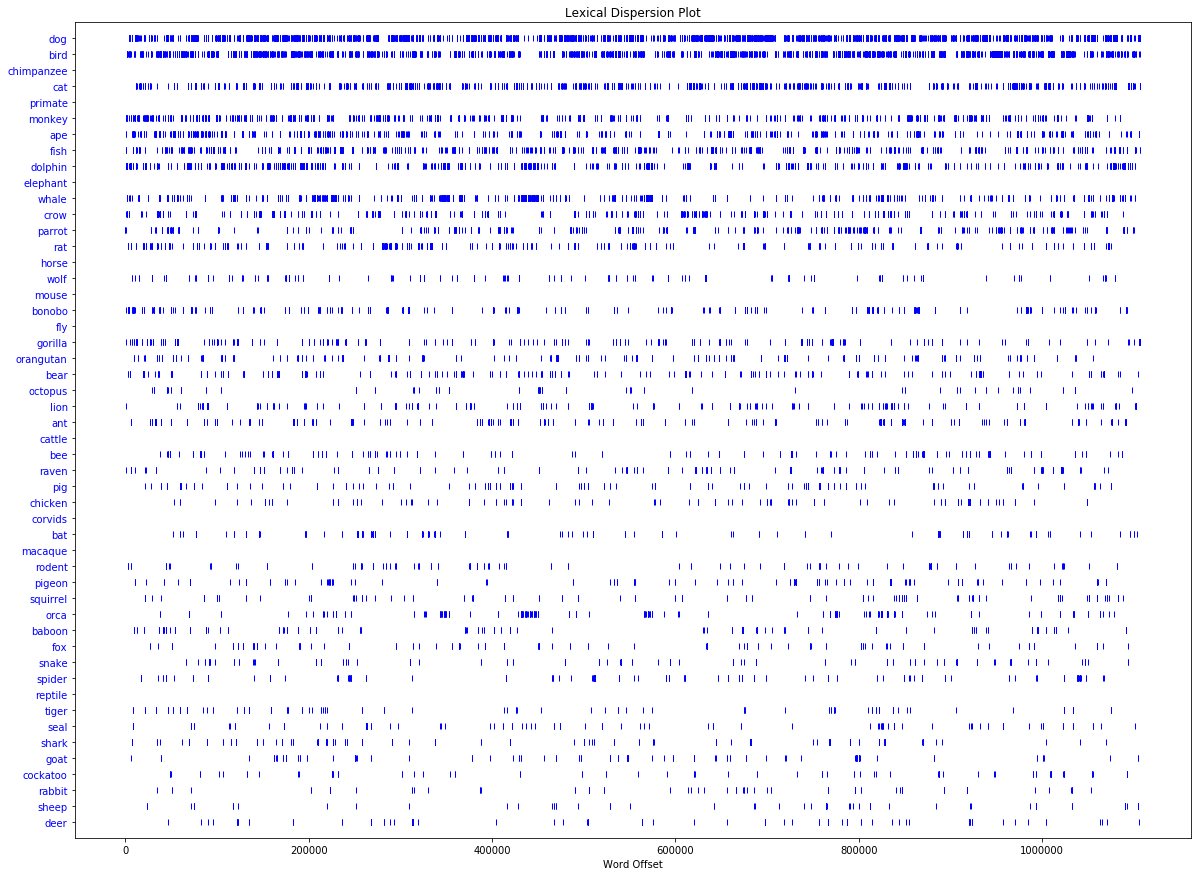

In [355]:
animals_score_animal_cognition = {animal:0 for animal in list_all_animals}
for ID, post in posts_animal_cognition.iteritems():
    if (posts_animal_cognition[ID]['animals_detected'] != 0):
        for i in (posts_animal_cognition[ID]['animals_detected']):
            animals_score_animal_cognition[i] += 1
top_animals_animal_cognition = zip(*sorted(animals_score_animal_cognition.items(), reverse=True, key= lambda x: x[1]))
top_animals_animal_cognition = list(top_animals_animal_cognition[0][:50])


for i in range(len(top_animals_animal_cognition)):
    animals = top_animals_animal_cognition[i].split('|')
    top_animals_animal_cognition[i] = animals[0]
    
text_animal_cognition = nltk.Text(text_animal_cognition)
text_animal_cognition.dispersion_plot(top_animals_animal_cognition)

* __Lexical Dispersion for Animal Cognition and Emotional Intelligence:__

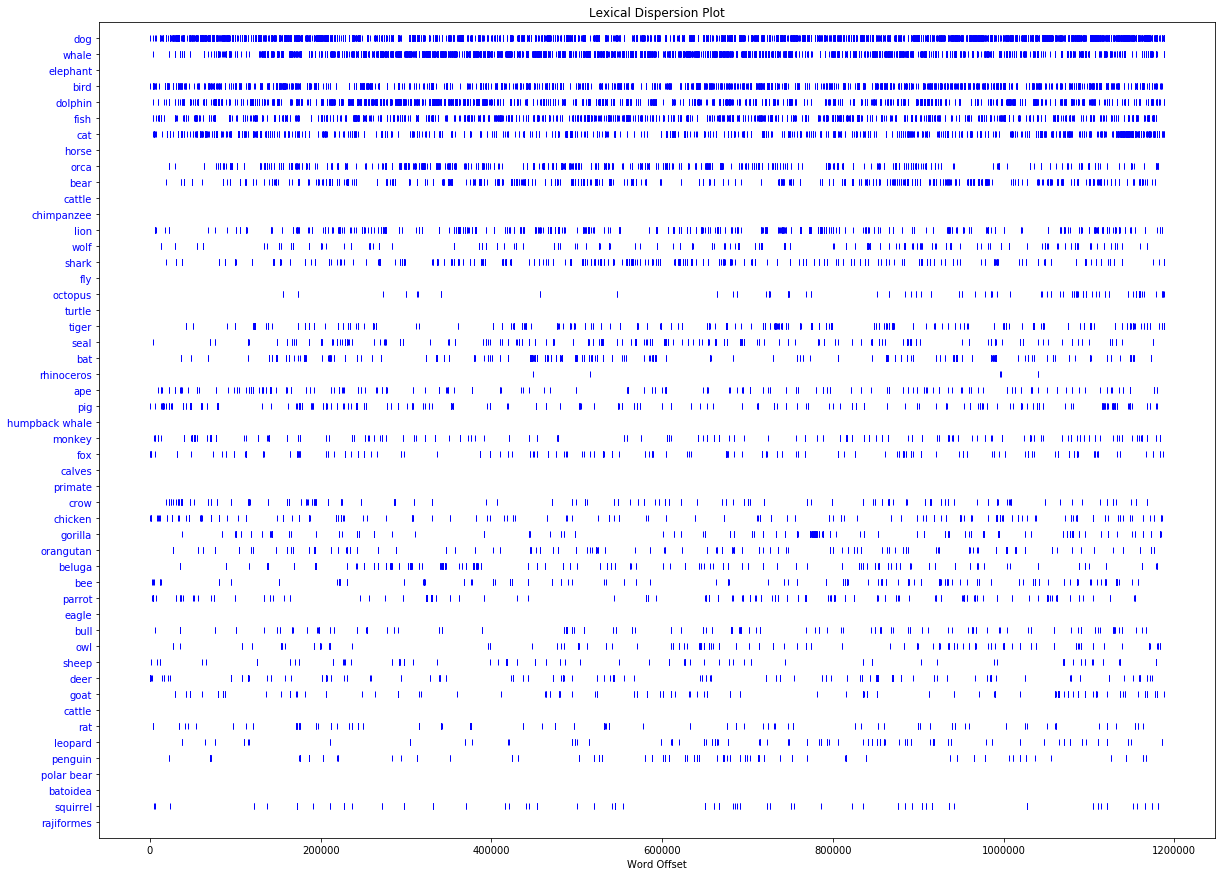

In [356]:
#adding a new key to the posts dict with the date in the right format

for ID in posts_animal_cognition_and_emotion.keys():
    posts_animal_cognition_and_emotion[ID]['date_time'] = datetime.strptime( posts_animal_cognition_and_emotion[ID]['created_time'][:19], '%Y-%m-%dT%H:%M:%S')

#creating a dictionary with date as key and text as value
date_text_animal_cognition_and_emotion = {}
for ID,post in posts_animal_cognition_and_emotion.iteritems():
    date_text_animal_cognition_and_emotion.update({posts_animal_cognition_and_emotion[ID]['date_time']: getTextTokensStemmedFromPost(post)})

#sorting the dictionary and creating a sorted list of tuples
sorted_date_text_animal_cognition_and_emotion = sorted(date_text_animal_cognition_and_emotion.items(), key=operator.itemgetter(0))

#appending each text from the posts, in order of creation to a string
text_animal_cognition_and_emotion = []

for i,j in sorted_date_text_animal_cognition_and_emotion:
    text_animal_cognition_and_emotion += j

# The words of interest for our lexical dispersion plot will be the top 50 most encountered animals in the posts of each group.

animals_score_animal_cognition_and_emotion = {animal:0 for animal in list_all_animals}
for ID, post in posts_animal_cognition_and_emotion.iteritems():
    if (posts_animal_cognition_and_emotion[ID]['animals_detected'] != 0):
        for i in (posts_animal_cognition_and_emotion[ID]['animals_detected']):
            animals_score_animal_cognition_and_emotion[i] += 1
top_animals_animal_cognition_and_emotion = zip(*sorted(animals_score_animal_cognition_and_emotion.items(), reverse=True, key= lambda x: x[1]))
top_animals_animal_cognition_and_emotion = list(top_animals_animal_cognition_and_emotion[0][:50])


for i in range(len(top_animals_animal_cognition_and_emotion)):
    animals = top_animals_animal_cognition_and_emotion[i].split('|')
    top_animals_animal_cognition_and_emotion[i] = animals[0]
    
text_animal_cognition_and_emotion = nltk.Text(text_animal_cognition_and_emotion)
text_animal_cognition_and_emotion.dispersion_plot(top_animals_animal_cognition_and_emotion)

* __Lexical Dispersion for Anthrozoology:__

In [522]:
#adding a new key to the posts dict with the date in the right format

for ID in posts_anthrozoology.keys():
    posts_anthrozoology[ID]['date_time'] = datetime.strptime( posts_anthrozoology[ID]['created_time'][:19], '%Y-%m-%dT%H:%M:%S')

#creating a dictionary with date as key and text as value
date_text_anthrozoology = {}
for ID,post in posts_anthrozoology.iteritems():
    date_text_anthrozoology.update({posts_anthrozoology[ID]['date_time']: getTextTokensStemmedFromPost(post)})

#sorting the dictionary and creating a sorted list of tuples
sorted_date_text_anthrozoology = sorted(date_text_anthrozoology.items(), key=operator.itemgetter(0))

#appending each text from the posts, in order of creation to a string
text_anthrozoology = []

for i,j in sorted_date_text_anthrozoology:
    text_anthrozoology += j

# The words of interest for our lexical dispersion plot will be the top 50 most encountered animals in the posts of each group.

animals_score_anthrozoology = {animal:0 for animal in list_all_animals}
for ID, post in posts_anthrozoology.iteritems():
    if (posts_anthrozoology[ID]['animals_detected'] != 0):
        for i in (posts_anthrozoology[ID]['animals_detected']):
            animals_score_anthrozoology[i] += 1
top_animals_anthrozoology = zip(*sorted(animals_score_anthrozoology.items(), reverse=True, key= lambda x: x[1]))
top_animals_anthrozoology = list(top_animals_anthrozoology[0][:50])


for i in range(len(top_animals_anthrozoology)):
    animals = top_animals_anthrozoology[i].split('|')
    top_animals_anthrozoology[i] = animals[0]
    
text_anthrozoology = nltk.Text(text_anthrozoology)
#text_anthrozoology.dispersion_plot(top_animals_anthrozoology)

### Which group is the most qualitative?
We evaluate this by looking at the type of posts, at how many of the posts have descriptions and how many words users add on each post.

In [437]:
animal_cognition = {}
animal_cognition_and_emotion = {}
anthrozoology = {}

posts_types = []
for ID, post in posts_anthrozoology.iteritems():
    posts_types.append(posts_anthrozoology[ID]['type'])


posts_types = set(posts_types)



for t in posts_types:
    animal_cognition.update({t: 0})
    animal_cognition_and_emotion.update({t: 0})
    anthrozoology.update({t: 0})
    
for post in posts_animal_cognition.values():
    animal_cognition[post['type']] += 1

for post in posts_animal_cognition_and_emotion.values():
    animal_cognition_and_emotion[post['type']] += 1
    
for post in posts_anthrozoology.values():
    anthrozoology[post['type']] += 1


#converting the number of different types into percentages:

for k in animal_cognition.keys():
    animal_cognition[k] = (animal_cognition[k]*1.0) / len(posts_animal_cognition)

for k in animal_cognition_and_emotion.keys():
    animal_cognition_and_emotion[k] = (animal_cognition_and_emotion[k]*1.0) / len(posts_animal_cognition_and_emotion)

for k in anthrozoology.keys():
    anthrozoology[k] = (anthrozoology[k]*1.0) / len(posts_anthrozoology)
    

In [559]:
for k, v in animal_cognition.iteritems():
    print k,v

status 0.132547441058
album 0.0
note 0.000143760782059
video 0.160005750431
link 0.654830362277
photo 0.0513225991949
event 0.00115008625647


In [560]:
   
for k, v in animal_cognition_and_emotion.iteritems():
    print k,v
 

status 0.0955229641065
album 0.0
note 9.64878425318e-05
video 0.209957545349
link 0.612311848707
photo 0.078927055191
event 0.00318409880355


In [561]:
   
for k, v in anthrozoology.iteritems():
    print k,v
    
    

status 0.148884708412
album 0.000134372480516
note 0.000403117441548
video 0.102257457673
link 0.675221714593
photo 0.0690674549852
event 0.00403117441548


# Conclusion

This was

## Appendix A - Getting the datasets from Facebook:
Downloading all the posts and members from all the groups using facebook's API

In [1]:
import facebook
import requests
import pickle

my_token = '' #secret, use your own
my_graph = facebook.GraphAPI(access_token = my_token)
animal_cognition = '326262904093291'
animal_cognition_and_emotion = '43506898972'
anthrozoology = '125591240543'

f = io.open('all_animals_v4.txt', 'r', encoding = 'utf-8')
list_all_animals = re.findall(r'\[\[(.*?)\]\]',f.read())
f.close()

In [2]:
posts = my_graph.get_object(id = animal_cognition_and_emotion, fields = 'feed.limit(200){attachments,comments.limit(200),reactions.limit(1000),sharedposts,message,story,updated_time,description}') 

In [4]:
members = my_graph.get_object(id = animal_cognition_and_emotion, fields = 'members.limit(200)')

In [ ]:
all_posts = {}
keep_going = True;
wtf = 0;

while(keep_going):
    if posts['feed'].has_key('data') == 0:
        wtf+=1;
        bla = posts['feed']
    else:
        for i in range(len(posts['feed']['data'])):
            ID = posts['feed']['data'][i]['id']
            t = posts['feed']['data'][i]['updated_time']
            
            if posts['feed']['data'][i].has_key('reactions'): # some posts don't reactions 
                    r = posts['feed']['data'][i]['reactions']
            else:
                    r = 0;
                    
            if posts['feed']['data'][i].has_key('description'):
                    d = posts['feed']['data'][i]['description']
            else:
                    d = 0;
            
            if posts['feed']['data'][i].has_key('attachments'):
                    a = posts['feed']['data'][i]['attachments']
            else:
                    a = 0;
                    
            if posts['feed']['data'][i].has_key('comments'):
                    c = posts['feed']['data'][i]['comments']
            else:
                    c = 0;
            
            if posts['feed']['data'][i].has_key('message'): # some posts don't have a message
                    m = posts['feed']['data'][i]['message']
            else:
                    m = 0;
                    
            if posts['feed']['data'][i].has_key('story'): # some posts don't have a story
                    s = posts['feed']['data'][i]['story']
            else:
                    s = 0;
            
            # default_data.update({'item3': 3})
            
            all_posts.update({ID: {'message': m,'story': s,'updated_time': t, 'reactions': r,
                            'description':d, 'attachments':a, 'comments':c }})    
        if (posts['feed'].has_key('paging') == 0):
            keep_going = False
        else:
            if posts['feed']['paging'].has_key("next"):
                posts['feed'] = requests.get(posts['feed']['paging']['next']).json()
            else:
                keep_going = False

In [ ]:
all_members = {}
keep_going = True

while(keep_going):
    for i in range(len(members['members']['data'])):
            ID = members['members']['data'][i]['id']
            n = members['members']['data'][i]['name']            
            all_members.update({ID: n })
        
    if members['members']['paging'].has_key("next"):
        members['members'] = requests.get(members['members']['paging']['next']).json()
    else:
        keep_going = False

In [ ]:
pickle.dump(all_posts, open('all_posts_animal_cognition.pkl', 'wb'), protocol=2) 
pickle.dump(all_members, open('all_members_animal_cognition.pkl', 'wb'), protocol=2) 

In [ ]:
import facebook
import requests
import pickle

my_token = '' #secret
my_graph = facebook.GraphAPI(access_token = my_token)
animal_cognition = '326262904093291'
animal_cognition_and_emotion = '43506898972'
anthrozoology = '125591240543'



posts = my_graph.get_object(id = animal_cognition_and_emotion, fields = 'feed.limit(200){attachments,comments.limit(200),reactions.limit(1000),sharedposts,message,story,updated_time,description}') 

members = my_graph.get_object(id = animal_cognition_and_emotion, fields = 'members.limit(200)')

all_posts = {}
keep_going = True;
wtf = 0;

while(keep_going):
    if posts['feed'].has_key('data') == 0:
        wtf+=1;
        bla = posts['feed']
    else:
        for i in range(len(posts['feed']['data'])):
            ID = posts['feed']['data'][i]['id']
            t = posts['feed']['data'][i]['updated_time']
            
            if posts['feed']['data'][i].has_key('reactions'): # some posts don't reactions 
                    r = posts['feed']['data'][i]['reactions']
            else:
                    r = 0;
                    
            if posts['feed']['data'][i].has_key('description'):
                    d = posts['feed']['data'][i]['description']
            else:
                    d = 0;
            
            if posts['feed']['data'][i].has_key('attachments'):
                    a = posts['feed']['data'][i]['attachments']
            else:
                    a = 0;
                    
            if posts['feed']['data'][i].has_key('comments'):
                    c = posts['feed']['data'][i]['comments']
            else:
                    c = 0;
            
            if posts['feed']['data'][i].has_key('message'): # some posts don't have a message
                    m = posts['feed']['data'][i]['message']
            else:
                    m = 0;
                    
            if posts['feed']['data'][i].has_key('story'): # some posts don't have a story
                    s = posts['feed']['data'][i]['story']
            else:
                    s = 0;
            
            # default_data.update({'item3': 3})
            
            all_posts.update({ID: {'message': m,'story': s,'updated_time': t, 'reactions': r,
                            'description':d, 'attachments':a, 'comments':c }})    
        if (posts['feed'].has_key('paging') == 0):
            keep_going = False
        else:
            if posts['feed']['paging'].has_key("next"):
                posts['feed'] = requests.get(posts['feed']['paging']['next']).json()
            else:
                keep_going = False

all_members = {}
keep_going = True

while(keep_going):
    for i in range(len(members['members']['data'])):
            ID = members['members']['data'][i]['id']
            n = members['members']['data'][i]['name']            
            all_members.update({ID: n })
        
    if members['members']['paging'].has_key("next"):
        members['members'] = requests.get(members['members']['paging']['next']).json()
    else:
        keep_going = False

pickle.dump(all_posts, open('all_posts_animal_cognition.pkl', 'wb'), protocol=2) 
pickle.dump(all_members, open('all_members_animal_cognition.pkl', 'wb'), protocol=2) 